# <span style="color:#006400">1 —ç—Ç–∞–ø: –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö</span>

## <span style="color:#006400">–ü–æ–¥–∫–ª—é—á–µ–Ω–∏–µ –±–∏–±–ª–∏–æ—Ç–µ–∫</span>

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import re
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from ydata_profiling import ProfileReport

## <span style="color:#006400">–ü—É—Ç—å –¥–æ –ø–∞–ø–∫–∏ </span>

In [75]:
current_dir = os.getcwd()
print(current_dir)
PATH_OUT = current_dir

df  = pd.read_csv(PATH_OUT+"//csv/rides.csv", 
                 sep=',', encoding='utf-8', decimal=',')
df2 = pd.read_csv(PATH_OUT+"//csv/weather.csv", 
                 sep=',', encoding='utf-8', decimal=',')

C:\Users\mailm\Yandex_AD_scooters\Jupyter notebooks


## <span style="color:#006400">–ü–æ–ª–µ–∑–Ω—ã–µ —Ñ—É–Ω–∫—Ü–∏–∏ –¥–ª—è —Ä–∞–±–æ—Ç—ã  </span>

In [76]:
#–ü—Ä–µ–æ–±—Ä–∞–∑—É–µ—Ç —á–∏—Å–ª–æ–≤–æ–π —Å—Ç–æ–ª–±–µ—Ü, —É–¥–∞–ª—è—è –¥—Ä–æ–±–Ω—É—é —á–∞—Å—Ç—å –∏ NaN, –ø—Ä–∏–≤–æ–¥—è –∫ —Ü–µ–ª—ã–º —á–∏—Å–ª–∞–º
def convert_id_column(df, column='Distance'):
    df = df.copy()
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    df[column] = df[column].str.replace('.0$', '', regex=True) 
    df[column] = df[column].str.replace('nan', '', regex=True)
    df[column] = pd.to_numeric(df[column], downcast='integer')
    return df

df = convert_id_column(df)

In [77]:
#–í—ã—á–∏—Å–ª—è–µ—Ç –¥–ª–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å —Å–µ—Å—Å–∏–∏ –º–µ–∂–¥—É 'Start Date' –∏ 'End Date' –≤ —Ñ–æ—Ä–º–∞—Ç–µ HH:MM:SS –∏ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ –≤ –º–∏–Ω—É—Ç–∞—Ö
def calculate_session_time(df):
    df = df.copy()
    df['Start Date'] = pd.to_datetime(df['Start Date'])
    df['End Date'] = pd.to_datetime(df['End Date'])
    df['Session Time'] = df['End Date'] - df['Start Date']
    df['Session Time'] = df['Session Time'].apply(
        lambda x: str(x).split()[-1] if 'days' in str(x) else str(x)
    )
    df['Session Time (minutes)'] = pd.to_timedelta(df['Session Time']).dt.total_seconds() / 60
    return df

df = calculate_session_time(df)
df.to_csv("datafrem_data.csv")  

In [78]:
def clean_data_with_threshold(df, variable, threshold, flag):
    """
    –û—á–∏—â–∞–µ—Ç DataFrame, —É–¥–∞–ª—è—è –∑–Ω–∞—á–µ–Ω–∏—è –≤ —É–∫–∞–∑–∞–Ω–Ω–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π, –∫–æ—Ç–æ—Ä—ã–µ –Ω–∞—Ö–æ–¥—è—Ç—Å—è –∑–∞ –ø—Ä–µ–¥–µ–ª–∞–º–∏ –∑–∞–¥–∞–Ω–Ω–æ–≥–æ –ø–æ—Ä–æ–≥–∞.
    –°–æ–∑–¥–∞–µ—Ç boxplot –¥–æ –∏ –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏.

    Args:
        df (pd.DataFrame): –í—Ö–æ–¥–Ω–æ–π DataFrame.
        variable (str): –ù–∞–∑–≤–∞–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–∞ –¥–ª—è –æ—á–∏—Å—Ç–∫–∏.
        threshold (float): –ü–æ—Ä–æ–≥–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ.
        flag (str):  –ï—Å–ª–∏ 'below', —É–¥–∞–ª—è–µ—Ç –∑–Ω–∞—á–µ–Ω–∏—è –º–µ–Ω—å—à–µ –ø–æ—Ä–æ–≥–∞.
                     –ï—Å–ª–∏ 'above', —É–¥–∞–ª—è–µ—Ç –∑–Ω–∞—á–µ–Ω–∏—è –±–æ–ª—å—à–µ –ø–æ—Ä–æ–≥–∞.
                     –ï—Å–ª–∏ 'both', —É–¥–∞–ª—è–µ—Ç –∑–Ω–∞—á–µ–Ω–∏—è –∫–∞–∫ –º–µ–Ω—å—à–µ, —Ç–∞–∫ –∏ –±–æ–ª—å—à–µ –ø–æ—Ä–æ–≥–∞ (–Ω—É–∂–µ–Ω –∫–æ—Ä—Ç–µ–∂ –∏–∑ –¥–≤—É—Ö –∑–Ω–∞—á–µ–Ω–∏–π).

    Returns:
        pd.DataFrame: –û—á–∏—â–µ–Ω–Ω—ã–π DataFrame.
    """

    # Boxplot –¥–æ –æ—á–∏—Å—Ç–∫–∏
    plot_numeric_boxplots(df)

    # –û—á–∏—Å—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö
    if flag == 'below':
        cleaned_df = df[df[variable] >= threshold].copy()  # –ò—Å–ø–æ–ª—å–∑—É–µ–º .copy(), —á—Ç–æ–±—ã –∏–∑–±–µ–∂–∞—Ç—å –ø—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏—è SettingWithCopyWarning
    elif flag == 'above':
        cleaned_df = df[df[variable] <= threshold].copy()  # –ò—Å–ø–æ–ª—å–∑—É–µ–º .copy(), —á—Ç–æ–±—ã –∏–∑–±–µ–∂–∞—Ç—å –ø—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏—è SettingWithCopyWarning
    elif flag == 'both':
        cleaned_df = df[(df[variable] >= threshold[0]) & (df[variable] <= threshold[1])].copy()  # –ò—Å–ø–æ–ª—å–∑—É–µ–º .copy(), —á—Ç–æ–±—ã –∏–∑–±–µ–∂–∞—Ç—å –ø—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏—è SettingWithCopyWarning
    else:
        raise ValueError("–ù–µ–¥–æ–ø—É—Å—Ç–∏–º–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ —Ñ–ª–∞–≥–∞. –î–æ–ª–∂–Ω–æ –±—ã—Ç—å 'below', 'above' –∏–ª–∏ 'both'.")


    # Boxplot –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏
    plot_numeric_boxplots(cleaned_df)
    
    return cleaned_df

## <span style="color:#006400">–ì—Ä–∞—Ñ–∏–∫–∏ –¥–ª—è –ø—Ä–æ—Å–º–æ—Ç—Ä–∞ –¥–∞–Ω–Ω—ã—Ö </span>

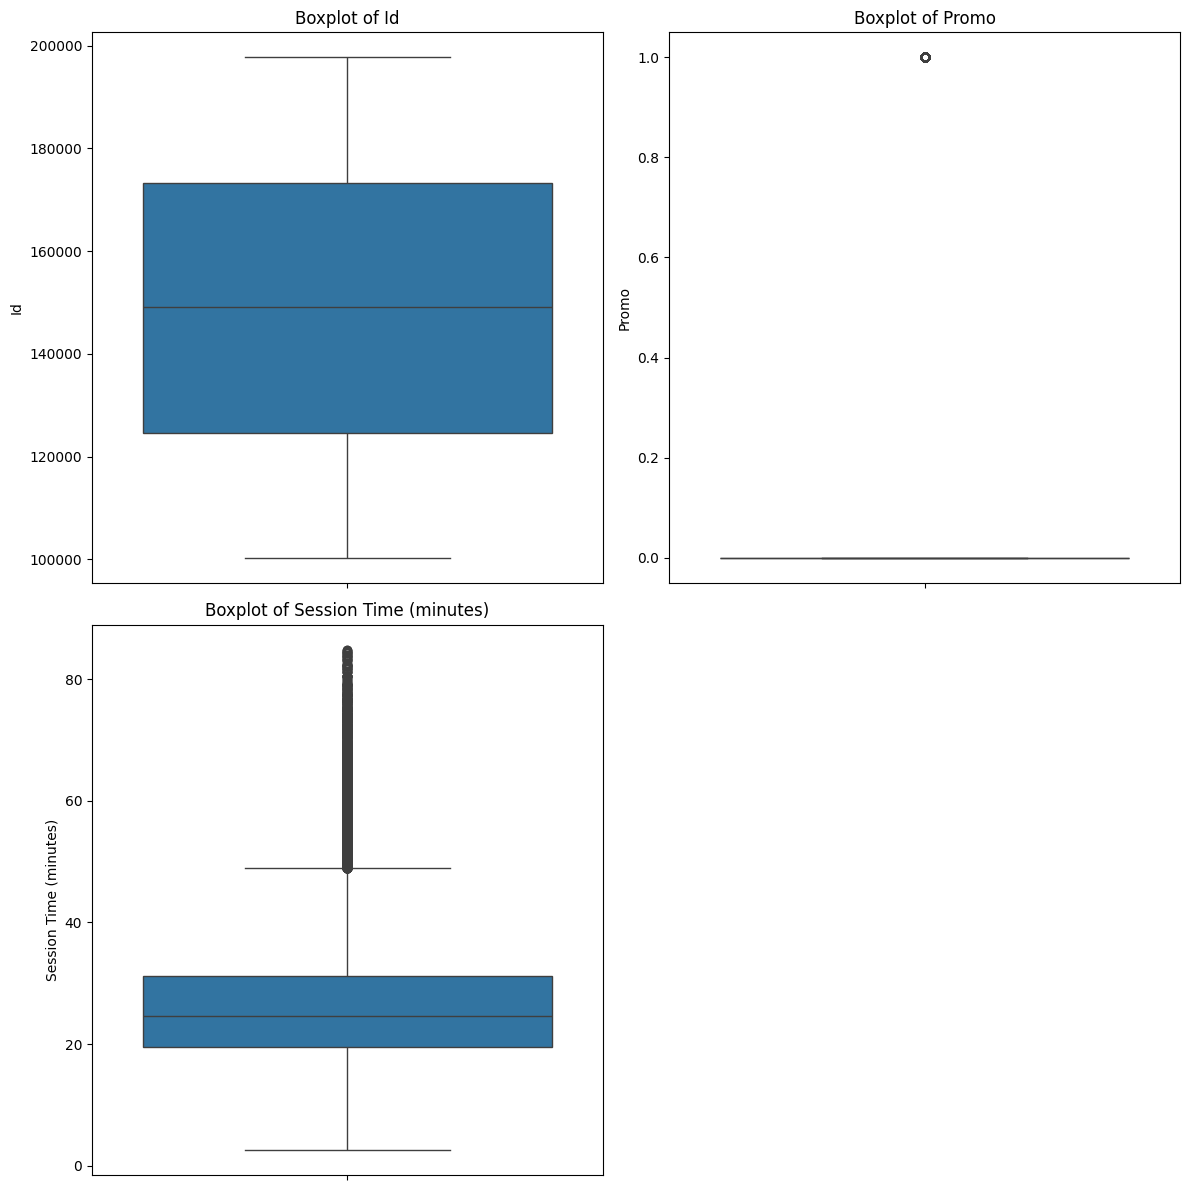

In [79]:
def plot_numeric_boxplots(df, figsize=(12, 6), plot_per_row=2):
    """
    –°—Ç—Ä–æ–∏—Ç boxplot'—ã –¥–ª—è –≤—Å–µ—Ö —á–∏—Å–ª–æ–≤—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤ –≤ DataFrame.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    -----------
    df : pandas.DataFrame
        –í—Ö–æ–¥–Ω–æ–π DataFrame —Å –¥–∞–Ω–Ω—ã–º–∏
    figsize : tuple, optional
        –†–∞–∑–º–µ—Ä –≥—Ä–∞—Ñ–∏–∫–∞ (—à–∏—Ä–∏–Ω–∞, –≤—ã—Å–æ—Ç–∞) –≤ –¥—é–π–º–∞—Ö, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é (12, 6)
    plot_per_row : int, optional
        –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ boxplot'–æ–≤ –≤ –æ–¥–Ω–æ–π —Å—Ç—Ä–æ–∫–µ, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 2
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    --------
    None
        –û—Ç–æ–±—Ä–∞–∂–∞–µ—Ç –≥—Ä–∞—Ñ–∏–∫–∏, –Ω–æ –Ω–µ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç –∑–Ω–∞—á–µ–Ω–∏–π
    """
    # –í—ã–±–µ—Ä–∏—Ç–µ —Ç–æ–ª—å–∫–æ —á–∏—Å–ª–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã (–∫–∞–∫ —Ü–µ–ª–æ—á–∏—Å–ª–µ–Ω–Ω—ã–µ, —Ç–∞–∫ –∏ —Å –ø–ª–∞–≤–∞—é—â–µ–π —Ç–æ—á–∫–æ–π).
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    n_columns = len(numeric_columns)
    
    if n_columns == 0:
        print("No numeric columns found in the DataFrame")
        return
    
    # –í—ã—á–∏—Å–ª–∏—Ç—å –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫
    n_rows = (n_columns + plot_per_row - 1) // plot_per_row
    
    # –°–æ–∑–¥–∞–Ω–∏–µ –ø–æ–¥–∑–∞–≥–æ–ª–æ–≤–∫–æ–≤
    fig, axes = plt.subplots(n_rows, plot_per_row, figsize=(figsize[0], figsize[1] * n_rows))
    
    # –°–≥–ª–∞–¥–∏—Ç—å –º–∞—Å—Å–∏–≤ –æ—Å–µ–π –¥–ª—è —É–ø—Ä–æ—â–µ–Ω–∏—è –∏—Ç–µ—Ä–∞—Ü–∏–∏
    if n_rows == 1 and plot_per_row == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # –°–æ–∑–¥–∞–Ω–∏–µ –∫–æ—Ä–æ–±–æ—á–Ω—ã—Ö –≥—Ä–∞—Ñ–∏–∫–æ–≤
    for idx, column in enumerate(numeric_columns):
        sns.boxplot(data=df, y=column, ax=axes[idx])
        axes[idx].set_title(f'Boxplot of {column}')
        axes[idx].set_ylabel(column)
    
    # –£–¥–∞–ª–∏—Ç—å –ø—É—Å—Ç—ã–µ –ø–æ–¥–∑–∞–≥–æ–ª–æ–≤–∫–∏, –µ—Å–ª–∏ —Ç–∞–∫–æ–≤—ã–µ –∏–º–µ—é—Ç—Å—è
    for idx in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()


# df = pd.DataFrame(your_data)
plot_numeric_boxplots(df)
# plot_numeric_boxplots(df2) - No numeric columns found in the DataFrame

## <span style="color:#006400">–ü—Ä–æ—Å–º–æ—Ç—Ä –∏–º–µ—é—à–∏—Ö—Å—è –¥–∞–Ω–Ω—ã—Ö  </span>

#### –î–∞–Ω–Ω—ã–µ –≤ rides.csv

In [80]:
df.head(10)

Id          Start Date            End Date Start Location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       –®–µ–≤—á–µ–Ω–∫–æ   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         –ß–µ—Ö–æ–≤–∞   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      –ë—É–¥–µ–Ω–Ω–æ–≥–æ   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          –¢—Ä—É–¥–∞   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   –ü–µ—Ä–≤–æ–º–∞–π—Å–∫–∞—è   
5  100345 2023-04-22 09:10:09 2023-04-22 09:49:56         –õ–µ—Å–Ω–∞—è   
6  100346 2023-04-22 09:15:12 2023-04-22 09:26:01   –ü—Ä–æ–ª–µ—Ç–∞—Ä—Å–∫–∞—è   
7  100347 2023-04-22 09:19:13 2023-04-22 09:40:03       –ö–æ–º–∞—Ä–æ–≤–∞   
8  100348 2023-04-22 09:21:42 2023-04-22 09:39:04       –ó–∞–ø–∞–¥–Ω–∞—è   
9  100349 2023-04-22 09:28:00 2023-04-22 10:02:08        –°–≤–æ–±–æ–¥—ã   

    Start District  End Location     End District  Distance  Promo  \
0    –Æ–≥–æ-–í–æ—Å—Ç–æ—á–Ω—ã–π       –ú–∞–π—Å–∫–∞—è      –û–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4069      0   
1         –∑–∞—Ä–µ—á–Ω—ã–π    –°–ø–æ—Ä—Ç–∏–≤–Ω–∞—è      –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4515      0   
2      –û–∫—Ç—è–±—Ä—å—Å–∫–∏–π      –°—É–≤–æ—Ä–æ–≤–∞        –ª–µ–Ω–∏–Ω—Å–∫–∏–π      4520      0   
3      –¶–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π       –†–∞–±–æ—á–∞—è  –°–µ–≤–µ—Ä–æ-–ó–∞–ø–∞–¥–Ω—ã–π      3881      0   
4  –°–µ–≤–µ—Ä–æ-–ó–∞–ø–∞–¥–Ω—ã–π     –Æ–±–∏–ª–µ–π–Ω–∞—è    –Æ–≥–æ-–í–æ—Å—Ç–æ—á–Ω—ã–π      4029      0   
5    –Æ–≥–æ-–í–æ—Å—Ç–æ—á–Ω—ã–π      –ó–∞–ø–∞–¥–Ω–∞—è        –õ–µ–Ω–∏–Ω—Å–∫–∏–π      4879      0   
6      –¶–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π       –°–≤–æ–±–æ–¥—ã        –õ–µ–Ω–∏–Ω—Å–∫–∏–π      1846      0   
7        –õ–µ–Ω–∏–Ω—Å–∫–∏–π  —É–ª. –∑–∞–ø–∞–¥–Ω–∞—è        –õ–µ–Ω–∏–Ω—Å–∫–∏–π      3133      0   
8        –ª–µ–Ω–∏–Ω—Å–∫–∏–π       –û–∑–µ—Ä–Ω–∞—è    –Æ–≥–æ-–í–æ—Å—Ç–æ—á–Ω—ã–π         3      0   
9        –ª–µ–Ω–∏–Ω—Å–∫–∏–π   —É–ª. —á–∫–∞–ª–æ–≤–∞    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π      5263      0   

  Session Time  Session Time (minutes)  
0     00:23:42               23.700000  
1     00:28:25               28.416667  
2     00:38:19               38.316667  
3     00:31:49               31.816667  
4     00:30:40               30.666667  
5     00:39:47               39.783333  
6     00:10:49               10.816667  
7     00:20:50               20.833333  
8     00:17:22               17.366667  
9     00:34:08               34.133333

In [81]:
#–ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ—Ç DataFrame: –ø—Ä–æ–≤–µ—Ä—è–µ—Ç –ø—Ä–æ–ø—É—Å–∫–∏, –¥—É–±–ª–∏–∫–∞—Ç—ã, –≤—ã–≤–æ–¥–∏—Ç —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –∏ –ø—Ä–∏–º–µ—Ä—ã –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤
def check_data(data_df):
    print ('\033[5m' + '–ò–∑—É—á–∏–º –∏—Å—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\n–ü—Ä–æ–≤–µ—Ä–∫–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤'+ '\033[0m')
    print ('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('–î–æ–ª—è –ø—Ä–æ–ø—É—Å–∫–æ–≤: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('–î–æ–ª—è —Å—Ç—Ä–æ–∫ —Å–æ–¥–µ—Ä–∂–∞—â–∏—Ö –ø—Ä–æ–ø—É—Å–∫–∏: {:.1%}'.format(missed_rows))

    ## –ü—Ä–æ–≤–µ—Ä–∏–º –¥—É–±–ª–∏–∫–∞—Ç—ã
    print ('\033[1m' + '\n–ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ –¥—É–±–ª–∏–∫–∞—Ç—ã'+ '\033[0m')
    print('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: ', data_df.duplicated().sum())

    ## –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Å–∞–º–∏ –¥–∞–Ω–Ω—ã–µ
    print ('\033[1m' + '\n–ü–µ—Ä–≤—ã–µ –ø—è—Ç—å —Å—Ç—Ä–æ–∫ –¥–∞—Ç–∞—Å–µ—Ç–∞'+ '\033[0m')
    display(data_df.head(2)) #tail()

    print('\033[1m' + '\n–û–ø–∏—Å–∞–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:'+ '\033[0m')
    display(data_df.describe().T)

    print('\033[1m' + '\n–û–ø–∏—Å–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:'+ '\033[0m')
    display(data_df.describe(include='object').T)

    print('\033[1m' + '\n–í—ã–≤–æ–¥ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ –∫–∞–∂–¥–æ–º—É –∫–∞—Ç–µ–≥–æ—Ä–∏–∞—å–Ω–æ–º—É –ø—Ä–∏–∑–Ω–∞–∫—É:'+ '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())


check_data(df)

–ò–∑—É—á–∏–º –∏—Å—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ
<class 'pandas.core.frame.DataFrame'>
Index: 101022 entries, 0 to 102254
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      101022 non-null  int64         
 1   Start Date              101022 non-null  datetime64[ns]
 2   End Date                100443 non-null  datetime64[ns]
 3   Start Location          101022 non-null  object        
 4   Start District          101022 non-null  object        
 5   End Location            101022 non-null  object        
 6   End District            101022 non-null  object        
 7   Distance                101022 non-null  int32         
 8   Promo                   101022 non-null  int64         
 9   Session Time            101022 non-null  object        
 10  Session Time (minutes)  100443 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int32(1), int64(2),

Id          Start Date            End Date Start Location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       –®–µ–≤—á–µ–Ω–∫–æ   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         –ß–µ—Ö–æ–≤–∞   

  Start District End Location End District  Distance  Promo Session Time  \
0  –Æ–≥–æ-–í–æ—Å—Ç–æ—á–Ω—ã–π      –ú–∞–π—Å–∫–∞—è  –û–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4069      0     00:23:42   
1       –∑–∞—Ä–µ—á–Ω—ã–π   –°–ø–æ—Ä—Ç–∏–≤–Ω–∞—è  –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4515      0     00:28:25   

   Session Time (minutes)  
0               23.700000  
1               28.416667


–û–ø–∏—Å–∞–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:


count                           mean  \
Id                      101022.0                  149019.395538   
Start Date                101022  2023-06-13 20:57:30.186236672   
End Date                  100443  2023-06-13 21:06:19.343727616   
Distance                101022.0                   27291.098424   
Promo                   101022.0                       0.019788   
Session Time (minutes)  100443.0                      26.369183   

                                        min                            25%  \
Id                                 100340.0                      124690.25   
Start Date              2023-04-22 09:01:03  2023-05-20 21:47:00.249999872   
End Date                2023-04-22 09:24:45     2023-05-20 22:11:22.500000   
Distance                                1.0                         3044.0   
Promo                                   0.0                            0.0   
Session Time (minutes)             2.566667                      19.466667   

                                        50%                            75%  \
Id                                 149027.5                      173342.75   
Start Date              2023-06-14 15:19:38  2023-07-08 19:36:17.249999872   
End Date                2023-06-14 15:10:55            2023-07-08 19:53:26   
Distance                             3702.0                         4429.0   
Promo                                   0.0                            0.0   
Session Time (minutes)            24.616667                      31.233333   

                                        max            std  
Id                                 197711.0   28103.094972  
Start Date              2023-07-31 23:57:01            NaN  
End Date                2023-08-01 00:42:12            NaN  
Distance                          7569789.0  309718.565282  
Promo                                   1.0       0.139271  
Session Time (minutes)            84.833333       9.946486


–û–ø–∏—Å–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:


count unique          top   freq
Start Location  101022    463   –õ–æ–º–æ–Ω–æ—Å–æ–≤–∞   1659
Start District  101022     13  –¶–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π  17885
End Location    101022    492   –°–ø–æ—Ä—Ç–∏–≤–Ω–∞—è   1497
End District    101022     14  –¶–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π  18662
Session Time    101022   3800          NaT    579


–í—ã–≤–æ–¥ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ –∫–∞–∂–¥–æ–º—É –∫–∞—Ç–µ–≥–æ—Ä–∏–∞—å–Ω–æ–º—É –ø—Ä–∏–∑–Ω–∞–∫—É:
_Start Location


Start Location
–õ–æ–º–æ–Ω–æ—Å–æ–≤–∞           1659
–õ—É–≥–æ–≤–∞—è              1633
–ú–∞–π—Å–∫–∞—è              1626
–í–æ—Å—Ç–æ—á–Ω–∞—è            1571
–°–ø–æ—Ä—Ç–∏–≤–Ω–∞—è           1560
                     ... 
–£–ª. –¶–µ–Ω—Ç—Ä–∞–ª—å–Ω–∞—è         1
–£–ª. –°–µ–≤–µ—Ä–Ω–∞—è            1
–£–ª. –≠–Ω—Ç—É–∑–∏–∞—Å—Ç–æ–≤         1
–£–ª. –ú–∞—Ç—Ä–æ—Å–æ–≤–∞           1
–£–ª. –ö–æ–º—Å–æ–º–æ–ª—å—Å–∫–∞—è       1
Name: count, Length: 463, dtype: int64

_Start District


Start District
–¶–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π        17885
–Æ–≥–æ-–í–æ—Å—Ç–æ—á–Ω—ã–π      13357
–°–µ–≤–µ—Ä–æ-–ó–∞–ø–∞–¥–Ω—ã–π    11175
–õ–µ–Ω–∏–Ω—Å–∫–∏–π          11169
–û–∫—Ç—è–±—Ä—å—Å–∫–∏–π         9612
—Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π         8164
–ó–∞—Ä–µ—á–Ω—ã–π            6723
—é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π       5806
–ª–µ–Ω–∏–Ω—Å–∫–∏–π           4960
—Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π     4918
–æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π         4282
–∑–∞—Ä–µ—á–Ω—ã–π            2970
—Å–µ–≤–µ—Ä–æ –∑–∞–ø–∞–¥–Ω—ã–π        1
Name: count, dtype: int64

_End Location


End Location
–°–ø–æ—Ä—Ç–∏–≤–Ω–∞—è      1497
–í–æ—Å—Ç–æ—á–Ω–∞—è       1428
–õ–æ–º–æ–Ω–æ—Å–æ–≤–∞      1424
–ë—É–¥–µ–Ω–Ω–æ–≥–æ       1388
–õ—É–≥–æ–≤–∞—è         1387
                ... 
—É–ª –ø–æ—á—Ç–æ–≤–∞—è        1
–£–ª. –ó–∞—Ä–µ—á–Ω–∞—è       1
–£–ª. –ú–∏—á—É—Ä–∏–Ω–∞       1
–£–ª. –®–µ–≤—á–µ–Ω–∫–æ       1
—É–ª –º–∞—Ç—Ä–æ—Å–æ–≤–∞       1
Name: count, Length: 492, dtype: int64

_End District


End District
–¶–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π        18662
–Æ–≥–æ-–í–æ—Å—Ç–æ—á–Ω—ã–π      14421
–õ–µ–Ω–∏–Ω—Å–∫–∏–π          11955
–°–µ–≤–µ—Ä–æ-–ó–∞–ø–∞–¥–Ω—ã–π    11926
–û–∫—Ç—è–±—Ä—å—Å–∫–∏–π        10390
–ó–∞—Ä–µ—á–Ω—ã–π            6905
—Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π         6724
—é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π       5152
—Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π     4353
–ª–µ–Ω–∏–Ω—Å–∫–∏–π           4252
–æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π         3749
–∑–∞—Ä–µ—á–Ω—ã–π            2478
–°–µ–≤–µ—Ä–æ –ó–∞–ø–∞–¥–Ω—ã–π       33
—Å–µ–≤–µ—Ä–æ –∑–∞–ø–∞–¥–Ω—ã–π       22
Name: count, dtype: int64

_Session Time


Session Time
NaT         579
00:22:37    110
00:20:23    109
00:21:37    105
00:20:22    104
           ... 
01:01:13      1
01:11:12      1
00:08:06      1
01:00:59      1
00:02:34      1
Name: count, Length: 3800, dtype: int64

#### –î–∞–Ω–Ω—ã–µ –≤ weather.csv

In [82]:
df2.head(10)

Datetime Temperature Precipitation Total  Wind Gust Wind Speed  \
0                  NaN          ¬∞C                  mm       km/h       km/h   
1  2023-04-01T00:00:00    8.740245                 0.1       48.6  21.638964   
2  2023-04-01T01:00:00    9.040245                 0.2      55.44  22.493519   
3  2023-04-01T02:00:00    8.880245                 0.3       55.8   22.26477   
4  2023-04-01T03:00:00    8.690246                 0.3      55.44   21.94524   
5  2023-04-01T04:00:00    8.630245                 0.3      48.96   22.42427   
6  2023-04-01T05:00:00    8.430245                 0.5       48.6   22.91026   
7  2023-04-01T06:00:00    8.690246                 0.3  50.039997    23.1774   
8  2023-04-01T07:00:00    8.860246                 0.4      52.56  23.166216   
9  2023-04-01T08:00:00    8.640245                 0.5         63  20.371038   

  Cloud Cover Total Sunshine Duration  
0                 %               min  
1                90                 0  
2                74                 0  
3                72                 0  
4                77                 0  
5                78                 0  
6                77                 0  
7                98         0.5287884  
8                89          6.060605  
9                92          4.242425

In [83]:
#–ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ—Ç DataFrame: –ø—Ä–æ–≤–µ—Ä—è–µ—Ç –ø—Ä–æ–ø—É—Å–∫–∏, –¥—É–±–ª–∏–∫–∞—Ç—ã, –≤—ã–≤–æ–¥–∏—Ç —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –∏ –ø—Ä–∏–º–µ—Ä—ã –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤
def check_data(data_df):
    print ('\033[5m' + '–ò–∑—É—á–∏–º –∏—Å—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\n–ü—Ä–æ–≤–µ—Ä–∫–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤'+ '\033[0m')
    print ('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('–î–æ–ª—è –ø—Ä–æ–ø—É—Å–∫–æ–≤: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('–î–æ–ª—è —Å—Ç—Ä–æ–∫ —Å–æ–¥–µ—Ä–∂–∞—â–∏—Ö –ø—Ä–æ–ø—É—Å–∫–∏: {:.1%}'.format(missed_rows))

    ## –ü—Ä–æ–≤–µ—Ä–∏–º –¥—É–±–ª–∏–∫–∞—Ç—ã
    print ('\033[1m' + '\n–ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ –¥—É–±–ª–∏–∫–∞—Ç—ã'+ '\033[0m')
    print('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: ', data_df.duplicated().sum())

    ## –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Å–∞–º–∏ –¥–∞–Ω–Ω—ã–µ
    print ('\033[1m' + '\n–ü–µ—Ä–≤—ã–µ –ø—è—Ç—å —Å—Ç—Ä–æ–∫ –¥–∞—Ç–∞—Å–µ—Ç–∞'+ '\033[0m')
    display(data_df.head(2)) #tail()

    print('\033[1m' + '\n–û–ø–∏—Å–∞–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:'+ '\033[0m')
    display(data_df.describe().T)

    print('\033[1m' + '\n–û–ø–∏—Å–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:'+ '\033[0m')
    display(data_df.describe(include='object').T)

    print('\033[1m' + '\n–í—ã–≤–æ–¥ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ –∫–∞–∂–¥–æ–º—É –∫–∞—Ç–µ–≥–æ—Ä–∏–∞—å–Ω–æ–º—É –ø—Ä–∏–∑–Ω–∞–∫—É:'+ '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())


check_data(df2)

–ò–∑—É—á–∏–º –∏—Å—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Datetime             3672 non-null   object
 1   Temperature          3618 non-null   object
 2   Precipitation Total  3643 non-null   object
 3   Wind Gust            3673 non-null   object
 4   Wind Speed           3657 non-null   object
 5   Cloud Cover Total    3653 non-null   object
 6   Sunshine Duration    3661 non-null   object
dtypes: object(7)
memory usage: 201.0+ KB
None

–ü—Ä–æ–≤–µ—Ä–∫–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤: 134
–î–æ–ª—è –ø—Ä–æ–ø—É—Å–∫–æ–≤: 0.6%
–î–æ–ª—è —Å—Ç—Ä–æ–∫ —Å–æ–¥–µ—Ä–∂–∞—â–∏—Ö –ø—Ä–æ–ø—É—Å–∫–∏: 3.6%

–ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ –¥—É–±–ª–∏–∫–∞—Ç—ã
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤:  0

–ü–µ—Ä–≤—ã–µ –ø—è—Ç—å —Å—Ç—Ä–æ–∫ –¥–∞—Ç–∞—Å–µ—Ç–∞


Datetime Temperature Precipitation Total Wind Gust Wind Speed  \
0                  NaN          ¬∞C                  mm      km/h       km/h   
1  2023-04-01T00:00:00    8.740245                 0.1      48.6  21.638964   

  Cloud Cover Total Sunshine Duration  
0                 %               min  
1                90                 0


–û–ø–∏—Å–∞–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:


count unique                  top  freq
Datetime             3672   3672  2023-08-31T23:00:00     1
Temperature          3618   1964            27.540245     9
Precipitation Total  3643     36                    0  2966
Wind Gust            3673    163           11.5199995    86
Wind Speed           3657    709            4.3349743    36
Cloud Cover Total    3653    197                    0   251
Sunshine Duration    3661    495                    0  1309


–û–ø–∏—Å–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:


count unique                  top  freq
Datetime             3672   3672  2023-08-31T23:00:00     1
Temperature          3618   1964            27.540245     9
Precipitation Total  3643     36                    0  2966
Wind Gust            3673    163           11.5199995    86
Wind Speed           3657    709            4.3349743    36
Cloud Cover Total    3653    197                    0   251
Sunshine Duration    3661    495                    0  1309


–í—ã–≤–æ–¥ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ –∫–∞–∂–¥–æ–º—É –∫–∞—Ç–µ–≥–æ—Ä–∏–∞—å–Ω–æ–º—É –ø—Ä–∏–∑–Ω–∞–∫—É:
_Datetime


Datetime
2023-08-31T23:00:00    1
2023-04-01T00:00:00    1
2023-04-01T01:00:00    1
2023-04-01T02:00:00    1
2023-04-01T03:00:00    1
                      ..
2023-04-01T12:00:00    1
2023-04-01T11:00:00    1
2023-04-01T10:00:00    1
2023-04-01T09:00:00    1
2023-04-01T08:00:00    1
Name: count, Length: 3672, dtype: int64

_Temperature


Temperature
27.540245     9
25.610245     8
15.040245     8
11.250245     7
20.140245     6
             ..
15.410245     1
14.290245     1
14.850245     1
13.3102455    1
12.710245     1
Name: count, Length: 1964, dtype: int64

_Precipitation Total


Precipitation Total
0      2966
0.1     146
0.2     144
0.3      89
0.4      54
0.6      38
0.5      33
0.8      23
0.7      21
1.2      15
1.3      15
0.9      13
1.1      12
1.4      10
1         8
1.6       7
1.5       7
1.8       6
1.7       6
2.2       6
2.1       4
2.4       2
2.3       2
2         2
1.9       2
2.6       2
mm        1
2.9       1
3         1
5         1
5.8       1
3.3       1
3.9       1
3.4       1
2.8       1
2.7       1
Name: count, dtype: int64

_Wind Gust


Wind Gust
11.5199995    86
13.32         81
11.879999     73
13.679999     73
15.4800005    72
              ..
67.67999       1
65.520004      1
66.96          1
65.159996      1
58.679996      1
Name: count, Length: 163, dtype: int64

_Wind Speed


Wind Speed
4.3349743    36
5.3517847    34
6.28713      33
3.319036     33
4.0249224    32
             ..
23.132626     1
25.600533     1
22.42427      1
21.94524      1
22.26477      1
Name: count, Length: 709, dtype: int64

_Cloud Cover Total


Cloud Cover Total
0            251
100           97
1             56
98            48
20            45
            ... 
19.2           1
14.1           1
18.300001      1
14.400001      1
13.500001      1
Name: count, Length: 197, dtype: int64

_Sunshine Duration


Sunshine Duration
0            1309
60            143
41.81818       37
59.393936      31
4.8484864      28
             ... 
2.2343435       1
26.962963       1
19.630304       1
53.81818        1
32.435688       1
Name: count, Length: 495, dtype: int64

## <span style="color:#006400">–ù–∞—á–∞–ª–æ –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏  </span>

### –î–∞–Ω–Ω—ã–µ –≤ rides.csv

#### –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤—Å–µ —Å—Ç–æ–ª–±—Ü—ã –≤ —Å—Ç–∞–Ω–¥–∞—Ä–¥ pep-8

In [84]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       –®–µ–≤—á–µ–Ω–∫–æ   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         –ß–µ—Ö–æ–≤–∞   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      –ë—É–¥–µ–Ω–Ω–æ–≥–æ   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          –¢—Ä—É–¥–∞   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   –ü–µ—Ä–≤–æ–º–∞–π—Å–∫–∞—è   

    start_district end_location     end_district  distance  promo  \
0    –Æ–≥–æ-–í–æ—Å—Ç–æ—á–Ω—ã–π      –ú–∞–π—Å–∫–∞—è      –û–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4069      0   
1         –∑–∞—Ä–µ—á–Ω—ã–π   –°–ø–æ—Ä—Ç–∏–≤–Ω–∞—è      –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4515      0   
2      –û–∫—Ç—è–±—Ä—å—Å–∫–∏–π     –°—É–≤–æ—Ä–æ–≤–∞        –ª–µ–Ω–∏–Ω—Å–∫–∏–π      4520      0   
3      –¶–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      –†–∞–±–æ—á–∞—è  –°–µ–≤–µ—Ä–æ-–ó–∞–ø–∞–¥–Ω—ã–π      3881      0   
4  –°–µ–≤–µ—Ä–æ-–ó–∞–ø–∞–¥–Ω—ã–π    –Æ–±–∏–ª–µ–π–Ω–∞—è    –Æ–≥–æ-–í–æ—Å—Ç–æ—á–Ω—ã–π      4029      0   

  session_time  session_time_(minutes)  
0     00:23:42               23.700000  
1     00:28:25               28.416667  
2     00:38:19               38.316667  
3     00:31:49               31.816667  
4     00:30:40               30.666667

#### –Ω–∞–≤–µ–¥–µ–º –ø–æ—Ä—è–¥–æ–∫ –≤ —Ç–∏–ø–∞—Ö –¥–∞–Ω–Ω—ã—Ö

##### –ë—ã–ª–æ: 

In [85]:
df.dtypes

id                                 int64
start_date                datetime64[ns]
end_date                  datetime64[ns]
start_location                    object
start_district                    object
end_location                      object
end_district                      object
distance                           int32
promo                              int64
session_time                      object
session_time_(minutes)           float64
dtype: object

##### –°—Ç–∞–ª–æ:

In [86]:
# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–æ–≤ —Å –ª–æ–∫–∞—Ü–∏—è–º–∏ –≤ —Å—Ç—Ä–æ–∫–æ–≤—ã–π —Ç–∏–ø (text/string)
location_columns = ['start_location', 'start_district', 'end_location', 'end_district']
df[location_columns] = df[location_columns].astype('string')

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ —Å—Ç—Ä–æ–∫—É —Ñ–æ—Ä–º–∞—Ç–∞ HH:MM:SS
df['session_time'] = pd.to_timedelta(df['session_time']).astype(str).str[-8:]
print(df.dtypes)

id                                 int64
start_date                datetime64[ns]
end_date                  datetime64[ns]
start_location            string[python]
start_district            string[python]
end_location              string[python]
end_district              string[python]
distance                           int32
promo                              int64
session_time                      object
session_time_(minutes)           float64
dtype: object


In [87]:
# —Ç–∏–ø –¥–∞–Ω–Ω—ã—Ö –≤ session_time –º–æ–∂–Ω–æ —Å–¥–µ–ª–∞—Ç—å timedelta, –Ω–æ —Ç–æ–≥–¥–∞ –±—É–¥—É—Ç —É–∫–∞–∑—ã–≤–∞—Ç—å –¥–∞–Ω–Ω—ã–µ –≤ —Ñ–æ—Ä–º–∞—Ç–µ –¥–Ω–µ–π:—á–∞—Å–æ–≤:–º–∏–Ω—É—Ç:—Å–µ–∫—É–Ω–¥ –∞ –¥–ª—è –∫—Ä–∞—Å–æ—Ç—ã –ø–æ–∫–∞ —á—Ç–æ –æ—Å—Ç–∞–≤–ª—é 
# —Ç–∏–ø object. (–ø–æ–∑–∂–µ —É–ª–¥–∞–ª–∏—Ç—å —ç—Ç—É –∫–æ–ª–æ–Ω–∫—É(—Ç.–∫ –µ—Å—Ç—å Session Time (minutes)))

#### –û—á–∏—Å—Ç–∏–º –∏ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–∏–∑–∏—Ä—É–µ–º —Ñ–æ—Ä–º–∞—Ç—ã –∞–¥—Ä–µ—Å–æ–≤ ()

In [88]:
df['start_location'] = list(map(lambda x: x.lower().replace('—É–ª. ', '').replace('—É–ª.', '').replace('—É–ª ', ''), df['start_location']))
df['end_location'] = list(map(lambda x: x.lower().replace('—É–ª. ', '').replace('—É–ª.', '').replace('—É–ª ', ''), df['end_location']))
df['start_district'] = list(map(lambda x: x.lower(), df['start_district']))
df['end_district'] = list(map(lambda x: x.lower(), df['end_district']))
df

id          start_date            end_date start_location  \
0       100340 2023-04-22 09:01:03 2023-04-22 09:24:45       —à–µ–≤—á–µ–Ω–∫–æ   
1       100341 2023-04-22 09:01:07 2023-04-22 09:29:32         —á–µ—Ö–æ–≤–∞   
2       100342 2023-04-22 09:04:27 2023-04-22 09:42:46      –±—É–¥–µ–Ω–Ω–æ–≥–æ   
3       100343 2023-04-22 09:06:34 2023-04-22 09:38:23          —Ç—Ä—É–¥–∞   
4       100344 2023-04-22 09:09:27 2023-04-22 09:40:07   –ø–µ—Ä–≤–æ–º–∞–π—Å–∫–∞—è   
...        ...                 ...                 ...            ...   
102250  197707 2023-07-31 23:45:06 2023-08-01 00:06:55        –æ–∑–µ—Ä–Ω–∞—è   
102251  197708 2023-07-31 23:46:01 2023-08-01 00:25:35       –º–∏—á—É—Ä–∏–Ω–∞   
102252  197709 2023-07-31 23:48:04 2023-08-01 00:09:21     –ª–µ—Ä–º–æ–Ω—Ç–æ–≤–∞   
102253  197710 2023-07-31 23:51:41 2023-08-01 00:38:04      —Ä—è–±–∏–Ω–æ–≤–∞—è   
102254  197711 2023-07-31 23:57:01 2023-08-01 00:19:03     –º–æ–ª–æ–¥–µ–∂–Ω–∞—è   

         start_district  end_location     end_district  distance  promo  \
0         —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π       –º–∞–π—Å–∫–∞—è      –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4069      0   
1              –∑–∞—Ä–µ—á–Ω—ã–π    —Å–ø–æ—Ä—Ç–∏–≤–Ω–∞—è      –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4515      0   
2           –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      —Å—É–≤–æ—Ä–æ–≤–∞        –ª–µ–Ω–∏–Ω—Å–∫–∏–π      4520      0   
3           —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π       —Ä–∞–±–æ—á–∞—è  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π      3881      0   
4       —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π     —é–±–∏–ª–µ–π–Ω–∞—è    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π      4029      0   
...                 ...           ...              ...       ...    ...   
102250    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π  –ø–µ—Ä–≤–æ–º–∞–π—Å–∫–∞—è  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π      3302      0   
102251        –ª–µ–Ω–∏–Ω—Å–∫–∏–π       —Å–∞–¥–æ–≤–∞—è         –∑–∞—Ä–µ—á–Ω—ã–π      4992      0   
102252        –ª–µ–Ω–∏–Ω—Å–∫–∏–π     –∫—É–π–±—ã—à–µ–≤–∞      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      2781      0   
102253  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π   —ç–Ω–µ—Ä–≥–µ—Ç–∏–∫–æ–≤    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π      6466      0   
102254    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π   –º–∞—è–∫–æ–≤—Å–∫–æ–≥–æ      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      3561      0   

       session_time  session_time_(minutes)  
0          00:23:42               23.700000  
1          00:28:25               28.416667  
2          00:38:19               38.316667  
3          00:31:49               31.816667  
4          00:30:40               30.666667  
...             ...                     ...  
102250     00:21:49               21.816667  
102251     00:39:34               39.566667  
102252     00:21:17               21.283333  
102253     00:46:23               46.383333  
102254     00:22:02               22.033333  

[101022 rows x 11 columns]

### –î–∞–Ω–Ω—ã–µ –≤ weather.csv

#### –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤—Å–µ —Å—Ç–æ–ª–±—Ü—ã –≤ —Å—Ç–∞–Ω–¥–∞—Ä–¥ pep-8

In [89]:
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2.head()

datetime temperature precipitation_total wind_gust wind_speed  \
0                  NaN          ¬∞C                  mm      km/h       km/h   
1  2023-04-01T00:00:00    8.740245                 0.1      48.6  21.638964   
2  2023-04-01T01:00:00    9.040245                 0.2     55.44  22.493519   
3  2023-04-01T02:00:00    8.880245                 0.3      55.8   22.26477   
4  2023-04-01T03:00:00    8.690246                 0.3     55.44   21.94524   

  cloud_cover_total sunshine_duration  
0                 %               min  
1                90                 0  
2                74                 0  
3                72                 0  
4                77                 0

#### –Ω–∞–≤–µ–¥–µ–º –ø–æ—Ä—è–¥–æ–∫ –≤ —Ç–∏–ø–∞—Ö –¥–∞–Ω–Ω—ã—Ö

##### –ë—ã–ª–æ: 

In [90]:
df2.dtypes

datetime               object
temperature            object
precipitation_total    object
wind_gust              object
wind_speed             object
cloud_cover_total      object
sunshine_duration      object
dtype: object

##### –°—Ç–∞–ª–æ: 

In [91]:
#–ø–µ—Ä–≤—É—é —Å—Ç—Ä–æ–∫—É –Ω–∞–¥–æ —É–¥–∞–ª–∏—Ç—å, —á—Ç–æ–±—ã —Ç–∏–ø—ã –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞—Ç—å
units = {
    'temperature': '¬∞C',
    'precipitation_total': 'mm',
    'wind_gust': 'km/h',
    'wind_speed': 'km/h',
    'cloud_cover_total': '%',
    'sunshine_duration': 'min'
}

df2 = df2.iloc[1:].reset_index(drop=True)

df2 = df2.astype({
    'datetime': 'datetime64[ns]',
    'temperature': 'float64',
    'precipitation_total': 'float64',
    'wind_gust': 'float64',
    'wind_speed': 'float64',
    'cloud_cover_total': 'float64',
    'sunshine_duration': 'float64'
})
print(df2.dtypes)
df2

datetime               datetime64[ns]
temperature                   float64
precipitation_total           float64
wind_gust                     float64
wind_speed                    float64
cloud_cover_total             float64
sunshine_duration             float64
dtype: object


datetime  temperature  precipitation_total  wind_gust  \
0    2023-04-01 00:00:00     8.740245                  0.1  48.600000   
1    2023-04-01 01:00:00     9.040245                  0.2  55.440000   
2    2023-04-01 02:00:00     8.880245                  0.3  55.800000   
3    2023-04-01 03:00:00     8.690246                  0.3  55.440000   
4    2023-04-01 04:00:00     8.630245                  0.3  48.960000   
...                  ...          ...                  ...        ...   
3667 2023-08-31 19:00:00    16.940245                  0.0  10.799999   
3668 2023-08-31 20:00:00    16.630245                  0.0  11.159999   
3669 2023-08-31 21:00:00    17.080246                  0.1  17.640000   
3670 2023-08-31 22:00:00    17.180244                  0.0  21.599998   
3671 2023-08-31 23:00:00    17.360245                  0.0  21.240000   

      wind_speed  cloud_cover_total  sunshine_duration  
0      21.638964               90.0                0.0  
1      22.493519               74.0                0.0  
2      22.264770               72.0                0.0  
3      21.945240               77.0                0.0  
4      22.424270               78.0                0.0  
...          ...                ...                ...  
3667    1.080000               89.0                1.5  
3668    1.138420               83.0                0.0  
3669    3.396233               82.0                0.0  
3670    7.235910               80.0                0.0  
3671    7.235910               67.0                0.0  

[3672 rows x 7 columns]

## <span style="color:#006400">–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –¥—É–±–ª–∏–∫–∞—Ç—ã –∏ –ø—Ä–æ–ø—É—Å–∫–∏ </span>

### –î–∞–Ω–Ω—ã–µ –≤ rides.csv

#### –ü–æ–ª–Ω—ã–µ –¥—É–±–ª–∏–∫–∞—Ç—ã –∏ –ø–æ —Å—Ç–æ–ª–±—Ü–∞–º

In [92]:
duplicates = df[df.duplicated()]  # keep=False
print(f"–ù–∞–π–¥–µ–Ω–æ {len(duplicates)} –ø–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤")

–ù–∞–π–¥–µ–Ω–æ 4831 –ø–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤


In [93]:
df.isna().sum()

id                          0
start_date                  0
end_date                  579
start_location              0
start_district              0
end_location                0
end_district                0
distance                    0
promo                       0
session_time                0
session_time_(minutes)    579
dtype: int64

In [94]:
## –ø—Ä–∏ —É–¥–∞–ª–µ–Ω–∏–∏ –ø–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ –ø–æ–ª—É—á–∏–º  101022 - 4831 = 96191 —Å—Ç—Ä–æ–∫ –¥–∞–Ω–Ω—ã—Ö (—Å–µ–π—á–∞—Å –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç 579 –ø—Ä–æ–ø—É—Å–∫–æ–≤, –Ω–æ –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è –ø–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ 
## –ø–æ–ª—É—á–∏–º 555 –ø—Ä–æ–ø—É—Å–∫–æ–≤ (–ø—Ä–æ–≤–µ—Ä—è–ª –≤ –¥—Ä—É–≥–æ–º notebook)) –∏–∑ —ç—Ç–æ–≥–æ  —Å–ª–µ–¥—É–µ—Ç 2 –≤—ã–≤–æ–¥–∞ 1) –º—ã –º–æ–∂–µ–º –ø—Ä–æ—Å—Ç–æ —É–¥–∞–ª–∏—Ç—å –¥–∞–Ω–Ω—ã–µ –ø—Ä–æ–ø—É—Å–∫–∏ —Ç.–∫. –æ–Ω–∏ —Å–æ—Å—Ç–∞–≤–ª—è—é—Ç 
## –≤—Å–µ–≥–æ –ª–∏—à—å 0,58% –æ—Ç –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö ((555 * 100)/96191) –ª–∏–±–æ 2) –ø—Ä–æ–≤–µ–¥–µ–º –Ω–µ–±–æ–ª—å—à–æ–µ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –ø—Ä–æ–ø—É—Å–∫–æ–≤:    

#### –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ end_date 

In [95]:
#–í—ã–≤–æ–¥–∏—Ç —Ç–æ–ø-5 —Å—Ç–∞—Ä—Ç–æ–≤—ã—Ö —Ç–æ—á–µ–∫ –ø–æ–µ–∑–¥–æ–∫ —Å –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–º–∏ –¥–∞—Ç–∞–º–∏ –æ–∫–æ–Ω—á–∞–Ω–∏—è (end_date)
missing_data = df[df['end_date'].isna()]
print("–¢–∏–ø–∏—á–Ω—ã–µ —Å—Ç–∞—Ä—Ç–æ–≤—ã–µ —Ç–æ—á–∫–∏ –¥–ª—è –ø–æ–µ–∑–¥–æ–∫ –±–µ–∑ end_date:")
print(missing_data['start_location'].value_counts().head(5))

–¢–∏–ø–∏—á–Ω—ã–µ —Å—Ç–∞—Ä—Ç–æ–≤—ã–µ —Ç–æ—á–∫–∏ –¥–ª—è –ø–æ–µ–∑–¥–æ–∫ –±–µ–∑ end_date:
start_location
—Å–ø–æ—Ä—Ç–∏–≤–Ω–∞—è    21
–º–∞–π—Å–∫–∞—è       16
–≤–æ—Å—Ç–æ—á–Ω–∞—è     15
–ª–æ–º–æ–Ω–æ—Å–æ–≤–∞    13
–ª—É–≥–æ–≤–∞—è       13
Name: count, dtype: int64


In [96]:
# –ó–∞–ø–æ–ª–Ω–∏—Ç—å –ø—Ä–æ–ø—É—Å–∫–∏ —Å—Ä–µ–¥–Ω–∏–º –≤—Ä–µ–º–µ–Ω–µ–º –ø–æ–µ–∑–¥–∫–∏ –¥–ª—è —ç—Ç–∏—Ö –ª–æ–∫–∞—Ü–∏–π
# for location in ['–°–ø–æ—Ä—Ç–∏–≤–Ω–∞—è', '–õ–æ–º–æ–Ω–æ—Å–æ–≤–∞', '–ú–∞–π—Å–∫–∞—è', '–í–æ—Å—Ç–æ—á–Ω–∞—è', '–ß–µ—Ö–æ–≤–∞']:
#     avg_time = df[df['start_location'] == location]['session_time_(minutes)'].mean()
#     df.loc[(df['start_location'] == location) & (df['end_date'].isna()), 'session_time_(minutes)'] = avg_time
#     df.loc[(df['start_location'] == location) & (df['end_date'].isna()), 'end_date'] = \
#         df['start_date'] + pd.to_timedelta(avg_time, unit='minutes')

In [97]:
# —Ç–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º –º—ã –º–æ–∂–µ–º –∑–∞–ø–æ–ª–Ω–∏—Ç—å –ø—Ä–æ–ø—É—Å–∫–∏ —Å—Ä–µ–¥–Ω–∏–º –≤—Ä–µ–º–µ–Ω–µ–º –ø–æ–µ–∑–¥–∫–∏ –¥–ª—è —á–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞—é—à–∏—Ö—Å—è –ª–æ–∫–∞—Ü–∏–π

#### –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ø–æ–≤—Ç–æ—Ä—è—é—â–∏–µ—Å—è –∑–Ω–∞—á–µ–Ω–∏—è –≤ –¥—Ä—É–≥–∏—Ö —Å—Ç–æ–ª–±—Ü–∞—Ö

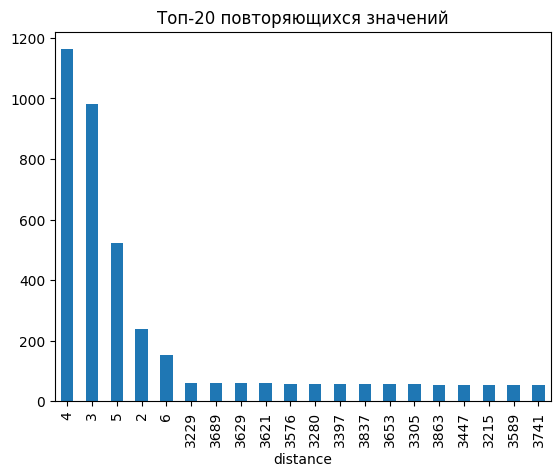

In [98]:
df['distance'].value_counts().head(20).plot(kind='bar')
plt.title("–¢–æ–ø-20 –ø–æ–≤—Ç–æ—Ä—è—é—â–∏—Ö—Å—è –∑–Ω–∞—á–µ–Ω–∏–π")
plt.show()

In [99]:
##—Å–ª–∏—à–∫–æ–º –º–Ω–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏–π <100 –≤ –∫–æ–ª–æ–Ω–∫–µ distance (–Ω—É–∂–Ω–æ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –≤–Ω–∏–º–∞—Ç–µ–ª—å–Ω–µ–µ –≤–æ–∑–º–æ–∂–Ω–æ —ç—Ç–æ –±—É–¥—É—Ç –≤—ã–±—Ä–æ—Å—ã) (–ø–æ—Ç–æ–º –º—ã –∏—Ö –æ—á–∏—Å—Ç–∏–ª–∏ —Å–º. –¥–∞–ª–µ–µ)

<span style="color:#006400">–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –≤—ã–±—Ä–æ—Å—ã(–µ—Å—Ç—å –ª–∏ –æ–Ω–∏ –≤–æ–æ–±—â–µ) ## </span>

#### –ó–∞–º–µ—Ç–∏–º –∏–∑ –ø—Ä–µ–¥—ã–¥—É—â–µ–≥–æ —à–∞–≥–∞, —á—Ç–æ –≤ distance –µ—Å—Ç—å –¥–∞–Ω–Ω—ã–µ <= 100 (250/500/1000)

In [100]:
df[df["distance"] <= 1000]

id          start_date            end_date start_location  \
8       100348 2023-04-22 09:21:42 2023-04-22 09:39:04       –∑–∞–ø–∞–¥–Ω–∞—è   
21      100360 2023-04-22 10:01:51 2023-04-22 10:31:17     –ª–µ—Ä–º–æ–Ω—Ç–æ–≤–∞   
67      100405 2023-04-22 11:08:22 2023-04-22 12:00:35         –ª–µ–Ω–∏–Ω–∞   
70      100408 2023-04-22 11:18:25 2023-04-22 11:36:19   —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω–∞—è   
108     100443 2023-04-22 12:16:46 2023-04-22 12:50:14      –∑–∞–≤–æ–¥—Å–∫–∞—è   
...        ...                 ...                 ...            ...   
102007  197473 2023-07-31 19:44:01 2023-07-31 20:29:57         –≥–æ–≥–æ–ª—è   
102072  197538 2023-07-31 20:23:15 2023-07-31 20:53:32        –ø–æ–ª–µ–≤–∞—è   
102117  197581 2023-07-31 20:57:53 2023-07-31 21:33:29    –æ–∫—Ç—è–±—Ä—å—Å–∫–∞—è   
102149  197611 2023-07-31 21:22:02 2023-07-31 21:40:39       —Ç—Ä—É–¥–æ–≤–∞—è   
102236  197693 2023-07-31 23:10:07 2023-07-31 23:23:49     –ø–∏–æ–Ω–µ—Ä—Å–∫–∞—è   

         start_district  end_location     end_district  distance  promo  \
8             –ª–µ–Ω–∏–Ω—Å–∫–∏–π       –æ–∑–µ—Ä–Ω–∞—è    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π         3      0   
21            –ª–µ–Ω–∏–Ω—Å–∫–∏–π        –¥—Ä—É–∂–±—ã      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π         5      0   
67            –ª–µ–Ω–∏–Ω—Å–∫–∏–π      –æ–≤—Ä–∞–∂–Ω–∞—è      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π         5      0   
70      —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π  —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω–∞—è  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π         4      0   
108     —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π     —Å–≤–µ—Ä–¥–ª–æ–≤–∞      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π         4      0   
...                 ...           ...              ...       ...    ...   
102007      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π   —ç–Ω—Ç—É–∑–∏–∞—Å—Ç–æ–≤      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π         3      0   
102072        –ª–µ–Ω–∏–Ω—Å–∫–∏–π       —á–∞–ø–∞–µ–≤–∞  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π         3      0   
102117         –∑–∞—Ä–µ—á–Ω—ã–π     —Å–æ–ª–Ω–µ—á–Ω–∞—è      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π         6      0   
102149      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π        –≥–æ–≥–æ–ª—è      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π         4      0   
102236         –∑–∞—Ä–µ—á–Ω—ã–π      –≥–æ—Ä—å–∫–æ–≥–æ    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π         3      0   

       session_time  session_time_(minutes)  
8          00:17:22               17.366667  
21         00:29:26               29.433333  
67         00:52:13               52.216667  
70         00:17:54               17.900000  
108        00:33:28               33.466667  
...             ...                     ...  
102007     00:45:56               45.933333  
102072     00:30:17               30.283333  
102117     00:35:36               35.600000  
102149     00:18:37               18.616667  
102236     00:13:42               13.700000  

[3122 rows x 11 columns]

In [101]:
# –í–∏–¥–Ω–æ, —á—Ç–æ –≤ distance	- 3122 –∑–Ω–∞—á–µ–Ω–∏—è <= 1000, –∏—Ö —Å—Ç–æ–∏—Ç —Å—á–∏—Ç–∞—Ç—å –≤—ã–±—Ä–æ—Å–∞–º–∏  —Ç.–∫. 
# 1) –û–Ω–∏ —Å–æ—Å—Ç–∞–≤–ª—è—é—Ç –∞–Ω–æ–º–∞–ª—å–Ω–æ –º–∞–ª—É—é –¥–∏—Å—Ç–∞–Ω—Ü–∏—é –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å –æ—Å–Ω–æ–≤–Ω—ã–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ–º –¥–∞–Ω–Ω—ã—Ö 
# 2) –ú–æ–≥—É—Ç –±—ã—Ç—å –æ—à–∏–±–∫–∞–º–∏ –∏–∑–º–µ—Ä–µ–Ω–∏–π –∏–ª–∏ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–º–∏ –∞—Ä—Ç–µ—Ñ–∞–∫—Ç–∞–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, —Ç–µ—Å—Ç–æ–≤—ã–µ –ø–æ–µ–∑–¥–∫–∏ –∏–ª–∏ —Å–±–æ–∏ GPS)

#### –ø—Ä–æ–≤–µ—Ä–∏–º –¥—Ä—É–≥–∏–µ —Å—Ç–æ–ª–±—Ü—ã 

In [102]:
df[df["session_time_(minutes)"] >= 60]

id          start_date            end_date start_location  \
357     100679 2023-04-22 16:21:14 2023-04-22 17:30:01      —Ä—è–±–∏–Ω–æ–≤–∞—è   
435     100751 2023-04-22 17:09:36 2023-04-22 18:23:37         —Ä–µ—á–Ω–∞—è   
544     100855 2023-04-22 18:28:51 2023-04-22 19:37:36        –º–∞–π—Å–∫–∞—è   
564     100874 2023-04-22 18:37:57 2023-04-22 19:43:22      —Ü–≤–µ—Ç–æ—á–Ω–∞—è   
661     100963 2023-04-22 19:28:01 2023-04-22 20:32:09    –æ–∫—Ç—è–±—Ä—å—Å–∫–∞—è   
...        ...                 ...                 ...            ...   
101366  196863 2023-07-31 08:32:44 2023-07-31 09:45:04         –ª–µ–Ω–∏–Ω–∞   
101779  197255 2023-07-31 16:44:38 2023-07-31 17:45:54        –æ–∑–µ—Ä–Ω–∞—è   
101839  197313 2023-07-31 17:45:13 2023-07-31 18:53:48        –∫—Ä–∞—Å–Ω–∞—è   
101929  197397 2023-07-31 18:59:00 2023-07-31 20:06:21      —Ä—è–±–∏–Ω–æ–≤–∞—è   
102111  197575 2023-07-31 20:54:18 2023-07-31 21:54:32     –ø–∏–æ–Ω–µ—Ä—Å–∫–∞—è   

         start_district   end_location     end_district  distance  promo  \
357     —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π       –Ω–∞–≥–æ—Ä–Ω–∞—è      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      5690      0   
435       —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π     —Å–ø–æ—Ä—Ç–∏–≤–Ω–∞—è      –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4466      0   
544         –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      —Å–æ–ª–Ω–µ—á–Ω–∞—è      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      5117      0   
564     —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π  –∫–æ–º—Å–æ–º–æ–ª—å—Å–∫–∞—è         –∑–∞—Ä–µ—á–Ω—ã–π      4134      0   
661            –∑–∞—Ä–µ—á–Ω—ã–π       –∫–æ–º–∞—Ä–æ–≤–∞        –ª–µ–Ω–∏–Ω—Å–∫–∏–π      6992      0   
...                 ...            ...              ...       ...    ...   
101366        –ª–µ–Ω–∏–Ω—Å–∫–∏–π     –ø–∏–æ–Ω–µ—Ä—Å–∫–∞—è         –∑–∞—Ä–µ—á–Ω—ã–π      7154      1   
101779    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π          –Ω–æ–≤–∞—è  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π      5537      0   
101839  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π    —ç–Ω–µ—Ä–≥–µ—Ç–∏–∫–æ–≤    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π      4935      0   
101929  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π   –¥–∑–µ—Ä–∂–∏–Ω—Å–∫–æ–≥–æ      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      5144      0   
102111         –∑–∞—Ä–µ—á–Ω—ã–π   –∫–∞—Ä–ª–∞ –º–∞—Ä–∫—Å–∞        –ª–µ–Ω–∏–Ω—Å–∫–∏–π      7130      0   

       session_time  session_time_(minutes)  
357        01:08:47               68.783333  
435        01:14:01               74.016667  
544        01:08:45               68.750000  
564        01:05:25               65.416667  
661        01:04:08               64.133333  
...             ...                     ...  
101366     01:12:20               72.333333  
101779     01:01:16               61.266667  
101839     01:08:35               68.583333  
101929     01:07:21               67.350000  
102111     01:00:14               60.233333  

[928 rows x 11 columns]

### –î–∞–Ω–Ω—ã–µ –≤ weather.csv

#### –ü–æ–ª–Ω—ã–µ –¥—É–±–ª–∏–∫–∞—Ç—ã –∏ –ø–æ —Å—Ç–æ–ª–±—Ü–∞–º

In [103]:
duplicates = df2[df2.duplicated()]
print(f"–ù–∞–π–¥–µ–Ω–æ {len(duplicates)} –ø–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤")

–ù–∞–π–¥–µ–Ω–æ 0 –ø–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤


In [104]:
df2.isna().sum()

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

#### –∑–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ –ø–æ —Å—Ç–æ–ª–±—Ü–∞–º

–∑–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ weather 

–ü—Ä–æ–ø—É—Å–∫–∏ –¥–æ –æ–±—Ä–∞–±–æ—Ç–∫–∏:
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64


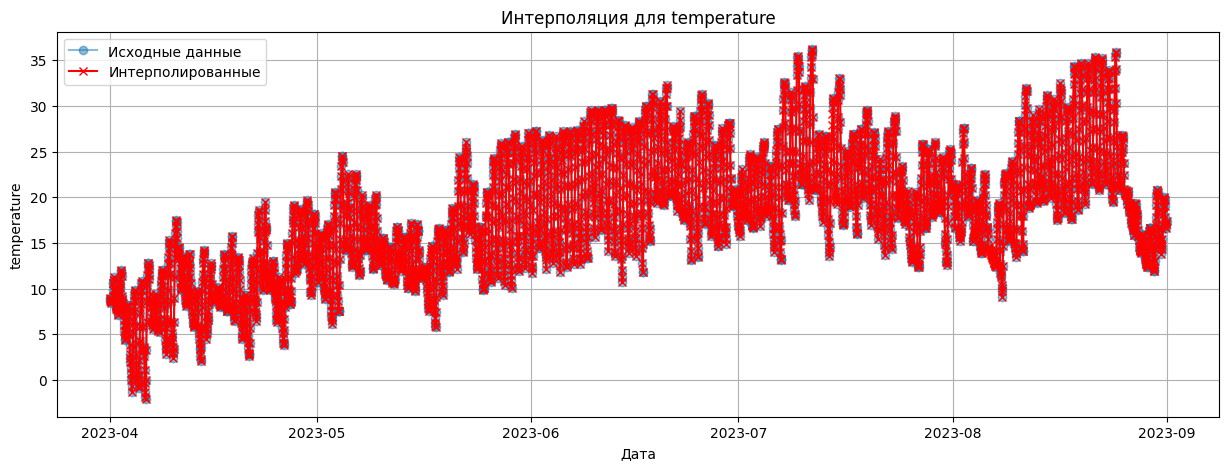

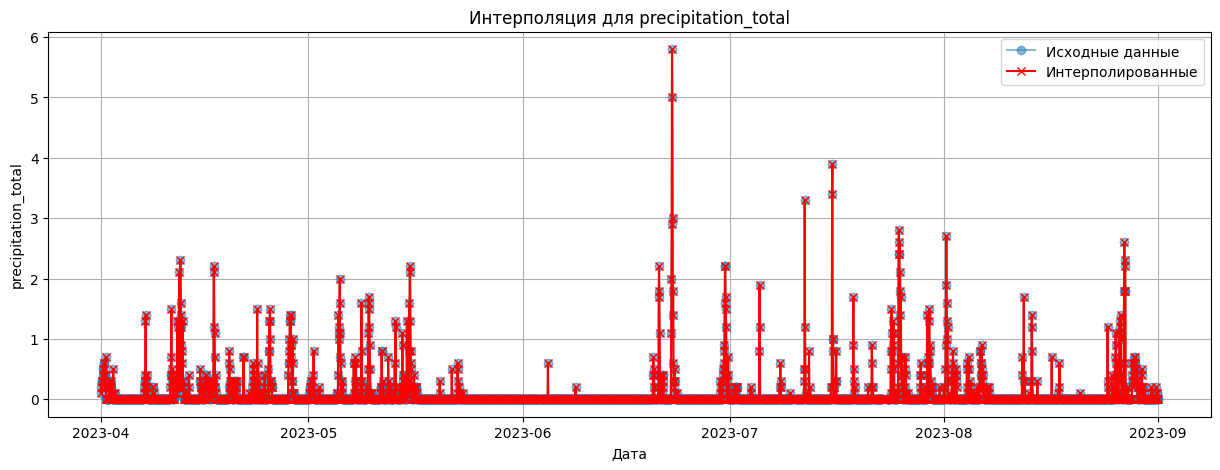

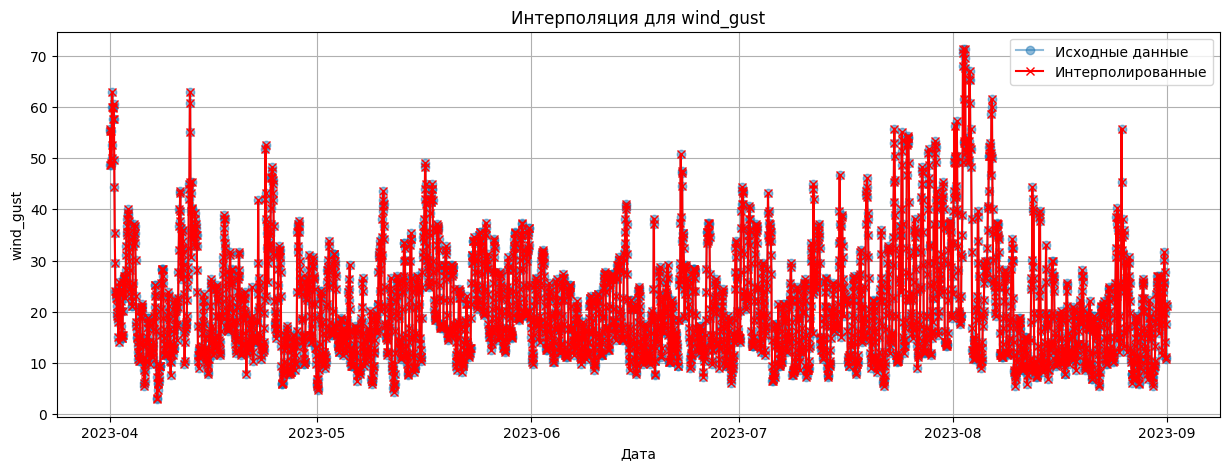

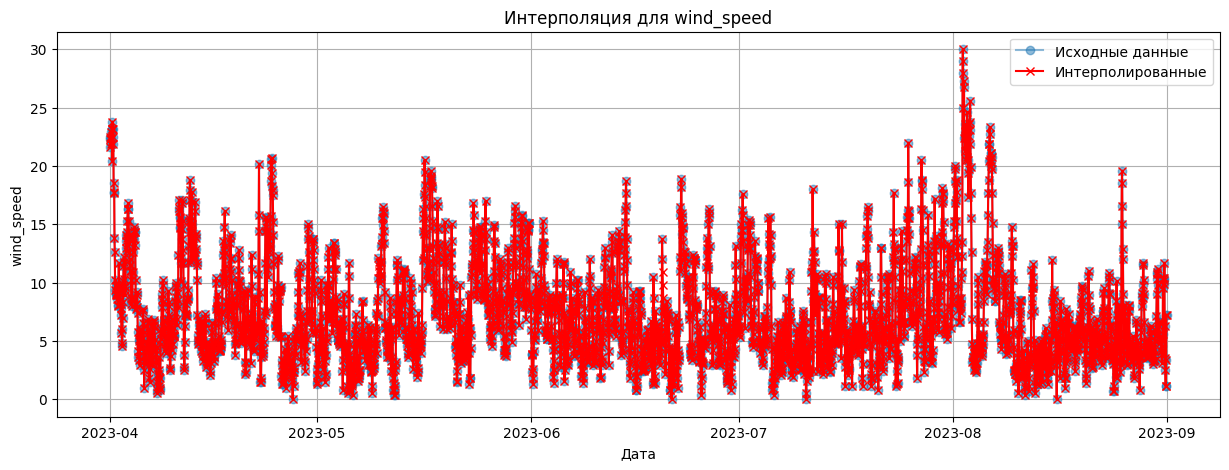

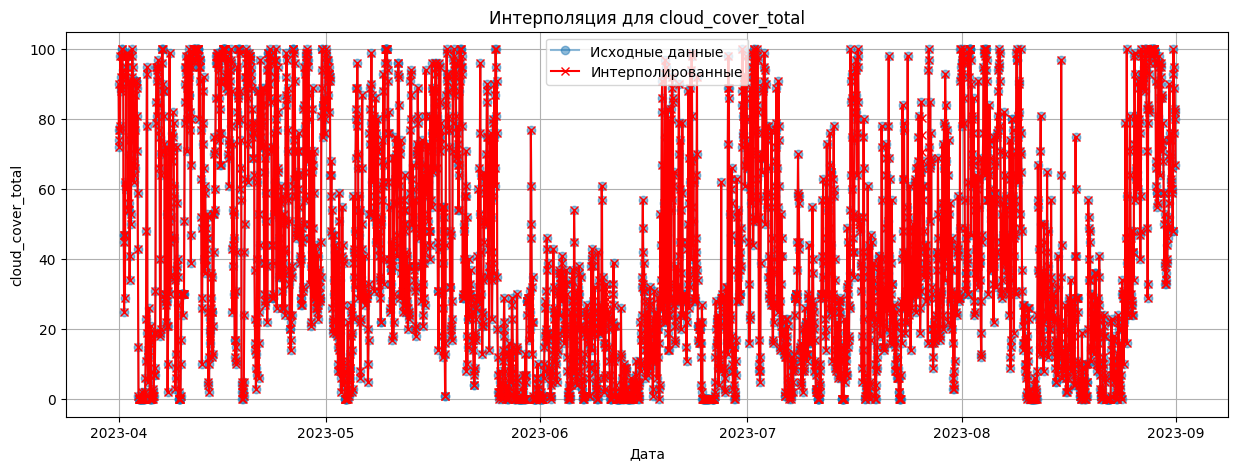

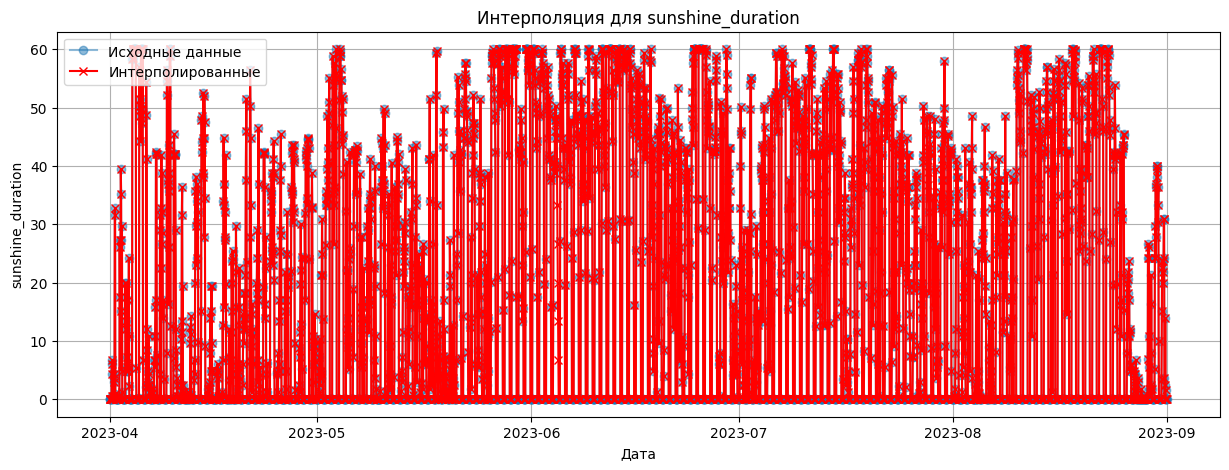


–ü—Ä–æ–ø—É—Å–∫–∏ –ø–æ—Å–ª–µ –æ–±—Ä–∞–±–æ—Ç–∫–∏:
temperature            0
precipitation_total    0
wind_gust              0
wind_speed             0
cloud_cover_total      0
sunshine_duration      0
dtype: int64


In [105]:
df2 = pd.read_csv("testwather2_data.csv", sep=',', encoding='utf-8')
df2.columns = df2.columns.str.lower().str.replace(' ', '_')

# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —Ç–∏–ø–æ–≤
df2['datetime'] = pd.to_datetime(df2['datetime'])
numeric_cols = ['temperature', 'precipitation_total', 'wind_gust', 'wind_speed', 
               'cloud_cover_total', 'sunshine_duration']
df2[numeric_cols] = df2[numeric_cols].apply(pd.to_numeric, errors='coerce')

# –£—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º datetime –≤ –∫–∞—á–µ—Å—Ç–≤–µ –∏–Ω–¥–µ–∫—Å–∞
df2.set_index('datetime', inplace=True)

# –ê–Ω–∞–ª–∏–∑ –ø—Ä–æ–ø—É—Å–∫–æ–≤
print("–ü—Ä–æ–ø—É—Å–∫–∏ –¥–æ –æ–±—Ä–∞–±–æ—Ç–∫–∏:")
print(df2.isna().sum())

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –∏–Ω—Ç–µ—Ä–ø–æ–ª—è—Ü–∏–∏ —Å –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–µ–π
def interpolate_and_plot(column, method='linear', limit=None, limit_direction='both'):
    original = df2[column].copy()
    interpolated = original.interpolate(method=method, limit=limit, limit_direction=limit_direction)
    
    # –î–ª—è –æ—Å—Ç–∞–≤—à–∏—Ö—Å—è –ø—Ä–æ–ø—É—Å–∫–æ–≤ –∏—Å–ø–æ–ª—å–∑—É–µ–º –∑–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –≤–ø–µ—Ä–µ–¥/–Ω–∞–∑–∞–¥
    if interpolated.isna().any():
        interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')
    
    plt.figure(figsize=(15, 5))
    plt.plot(original.index, original, 'o-', label='–ò—Å—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ', alpha=0.5)
    plt.plot(interpolated.index, interpolated, 'x-', label='–ò–Ω—Ç–µ—Ä–ø–æ–ª–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ', color='red')
    plt.title(f'–ò–Ω—Ç–µ—Ä–ø–æ–ª—è—Ü–∏—è –¥–ª—è {column}')
    plt.xlabel('–î–∞—Ç–∞')
    plt.ylabel(column)
    plt.legend()
    plt.grid()
    plt.show()
    
    return interpolated

# –ü—Ä–∏–º–µ–Ω—è–µ–º –∏–Ω—Ç–µ—Ä–ø–æ–ª—è—Ü–∏—é –∫ –∫–∞–∂–¥–æ–º—É —Å—Ç–æ–ª–±—Ü—É
for column in numeric_cols:
    df2[column] = interpolate_and_plot(column, method='time')  # –≤—Ä–µ–º–µ–Ω–Ω—É—é –∏–Ω—Ç–µ—Ä–ø–æ–ª—è—Ü–∏—é
    
print("\n–ü—Ä–æ–ø—É—Å–∫–∏ –ø–æ—Å–ª–µ –æ–±—Ä–∞–±–æ—Ç–∫–∏:")
print(df2.isna().sum())

assert df2.isna().sum().sum() == 0, "–û—Å—Ç–∞–ª–∏—Å—å –Ω–µ–∑–∞–ø–æ–ª–Ω–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è!"

## <span style="color:#006400">–£–¥–∞–ª–∏–º –≤—Å–µ –Ω–µ –Ω—É–∂–Ω–æ–µ / –ó–∞–ø–æ–ª–Ω–∏–º –≤—Å–µ –Ω—É–∂–Ω–æ–µ</span>

#### 1) —É–¥–∞–ª–∏–º –ø–æ–ª–Ω—ã–µ –¥—É–±–ª–∏–∫–∞—Ç—ã  (4831 —É–¥–∞–ª–∞—è–µ–º)

In [106]:
df = df.drop_duplicates()
df

id          start_date            end_date start_location  \
0       100340 2023-04-22 09:01:03 2023-04-22 09:24:45       —à–µ–≤—á–µ–Ω–∫–æ   
1       100341 2023-04-22 09:01:07 2023-04-22 09:29:32         —á–µ—Ö–æ–≤–∞   
2       100342 2023-04-22 09:04:27 2023-04-22 09:42:46      –±—É–¥–µ–Ω–Ω–æ–≥–æ   
3       100343 2023-04-22 09:06:34 2023-04-22 09:38:23          —Ç—Ä—É–¥–∞   
4       100344 2023-04-22 09:09:27 2023-04-22 09:40:07   –ø–µ—Ä–≤–æ–º–∞–π—Å–∫–∞—è   
...        ...                 ...                 ...            ...   
102250  197707 2023-07-31 23:45:06 2023-08-01 00:06:55        –æ–∑–µ—Ä–Ω–∞—è   
102251  197708 2023-07-31 23:46:01 2023-08-01 00:25:35       –º–∏—á—É—Ä–∏–Ω–∞   
102252  197709 2023-07-31 23:48:04 2023-08-01 00:09:21     –ª–µ—Ä–º–æ–Ω—Ç–æ–≤–∞   
102253  197710 2023-07-31 23:51:41 2023-08-01 00:38:04      —Ä—è–±–∏–Ω–æ–≤–∞—è   
102254  197711 2023-07-31 23:57:01 2023-08-01 00:19:03     –º–æ–ª–æ–¥–µ–∂–Ω–∞—è   

         start_district  end_location     end_district  distance  promo  \
0         —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π       –º–∞–π—Å–∫–∞—è      –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4069      0   
1              –∑–∞—Ä–µ—á–Ω—ã–π    —Å–ø–æ—Ä—Ç–∏–≤–Ω–∞—è      –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4515      0   
2           –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      —Å—É–≤–æ—Ä–æ–≤–∞        –ª–µ–Ω–∏–Ω—Å–∫–∏–π      4520      0   
3           —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π       —Ä–∞–±–æ—á–∞—è  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π      3881      0   
4       —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π     —é–±–∏–ª–µ–π–Ω–∞—è    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π      4029      0   
...                 ...           ...              ...       ...    ...   
102250    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π  –ø–µ—Ä–≤–æ–º–∞–π—Å–∫–∞—è  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π      3302      0   
102251        –ª–µ–Ω–∏–Ω—Å–∫–∏–π       —Å–∞–¥–æ–≤–∞—è         –∑–∞—Ä–µ—á–Ω—ã–π      4992      0   
102252        –ª–µ–Ω–∏–Ω—Å–∫–∏–π     –∫—É–π–±—ã—à–µ–≤–∞      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      2781      0   
102253  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π   —ç–Ω–µ—Ä–≥–µ—Ç–∏–∫–æ–≤    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π      6466      0   
102254    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π   –º–∞—è–∫–æ–≤—Å–∫–æ–≥–æ      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      3561      0   

       session_time  session_time_(minutes)  
0          00:23:42               23.700000  
1          00:28:25               28.416667  
2          00:38:19               38.316667  
3          00:31:49               31.816667  
4          00:30:40               30.666667  
...             ...                     ...  
102250     00:21:49               21.816667  
102251     00:39:34               39.566667  
102252     00:21:17               21.283333  
102253     00:46:23               46.383333  
102254     00:22:02               22.033333  

[96191 rows x 11 columns]

#### 2) –∑–∞–ø–æ–ª–Ω–∏–º –ø—Ä–æ–ø—É—Å–∫–∏ –≤ end_date –∏ session_time_(minutes) (—Å—Ä–∞–∑—É –æ–∫—Ä—É–≥–ª–∏–º —Å–¥–µ–ª–∞–≤ –¥–∞–Ω–Ω—ã–µ –∫—Ä–∞—Å–∏–≤—ã–º–∏)

In [107]:
df["distance"] = pd.to_numeric(df["distance"], errors="coerce")

# –£–¥–∞–ª–µ–Ω–∏–µ —Å—Ç—Ä–æ–∫ —Å –Ω–µ–∫–æ—Ä—Ä–µ–∫—Ç–Ω—ã–º–∏ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è–º–∏
df = df.dropna(subset=["distance"])

# –†–∞—Å—á–µ—Ç –ø—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ –ø–æ–µ–∑–¥–∫–∏ –≤ —á–∞—Å–∞—Ö
df["duration"] = (df["end_date"] - df["start_date"]).dt.total_seconds() / 3600

# –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è –≤–∞–ª–∏–¥–Ω—ã—Ö –∑–∞–ø–∏—Å–µ–π
valid_mask = (df["duration"] > 0) & (df["distance"] > 0)
valid_entries = df[valid_mask].copy()  # –Ø–≤–Ω–æ–µ —Å–æ–∑–¥–∞–Ω–∏–µ –∫–æ–ø–∏–∏

# –†–∞—Å—á–µ—Ç —Å—Ä–µ–¥–Ω–µ–π —Å–∫–æ—Ä–æ—Å—Ç–∏
valid_entries["speed"] = valid_entries["distance"] / valid_entries["duration"]
average_speed = valid_entries["speed"].median()

# –í–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ end_date –¥–ª—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤
duplicate_mask = df.duplicated(subset=["end_date"], keep=False)
df.loc[duplicate_mask, "end_date"] = df.loc[duplicate_mask, "start_date"] + pd.to_timedelta(
    df.loc[duplicate_mask, "distance"] / average_speed, 
    unit="h"
)

df = df.drop(columns=["duration"])

C:\Users\mailm\AppData\Local\Temp\ipykernel_13136\723006694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["distance"] = pd.to_numeric(df["distance"], errors="coerce")


In [108]:
df.isna().sum()

id                          0
start_date                  0
end_date                    0
start_location              0
start_district              0
end_location                0
end_district                0
distance                    0
promo                       0
session_time                0
session_time_(minutes)    555
dtype: int64

In [109]:
def calculate_session_time(df):
    df = df.copy()
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])
    
    # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º –ø—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –ø–æ–µ–∑–¥–∫–∏
    df['session_time'] = df['end_date'] - df['start_date']
    
    # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ —Å—Ç—Ä–æ–∫—É —Ñ–æ—Ä–º–∞—Ç–∞ HH:MM:SS (–±–µ–∑ –º–∏–ª–ª–∏—Å–µ–∫—É–Ω–¥)
    df['session_time'] = df['session_time'].apply(
        lambda x: str(x).split()[-1].split('.')[0] if 'days' in str(x) else str(x).split('.')[0]
    )
    
    # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º –ø—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –≤ –º–∏–Ω—É—Ç–∞—Ö –∏ –æ–∫—Ä—É–≥–ª—è–µ–º –¥–æ 6 –∑–Ω–∞–∫–æ–≤ –ø–æ—Å–ª–µ –∑–∞–ø—è—Ç–æ–π
    df['session_time_(minutes)'] = round(pd.to_timedelta(df['session_time']).dt.total_seconds() / 60, 6)
    
    # –û–∫—Ä—É–≥–ª—è–µ–º end_date –¥–æ —Å–µ–∫—É–Ω–¥ (—É–¥–∞–ª—è–µ–º –º–∏–ª–ª–∏—Å–µ–∫—É–Ω–¥—ã)
    df['end_date'] = df['end_date'].dt.floor('s')
    
    return df

df = calculate_session_time(df)

In [110]:
# –û–∫—Ä—É–≥–ª—è–µ–º —Å—Ç–æ–ª–±–µ—Ü 'session_time_(minutes)' –¥–æ 6 –∑–Ω–∞–∫–æ–≤ –ø–æ—Å–ª–µ –∑–∞–ø—è—Ç–æ–π
df['session_time_(minutes)'] = df['session_time_(minutes)'].round(1)

# –ò–ª–∏ –¥–æ 2 –∑–Ω–∞–∫–æ–≤, –µ—Å–ª–∏ –Ω—É–∂–Ω–æ:
# df['session_time_(minutes)'] = df['session_time_(minutes)'].round(2)

In [111]:
df.isna().sum()

id                        0
start_date                0
end_date                  0
start_location            0
start_district            0
end_location              0
end_district              0
distance                  0
promo                     0
session_time              0
session_time_(minutes)    0
dtype: int64

#### 3) —É–¥–∞–ª–∏–º  –∑–Ω–∞—á–µ–Ω–∏—è –∫–æ—Ç–æ—Ä—ã–µ —è–≤–ª—è—é—Ç—å—Å—è –≤—ã–±—Ä–æ—Å–∞–º–∏ –ø–æ –∫–æ–ª–æ–Ω–∫–µ distance

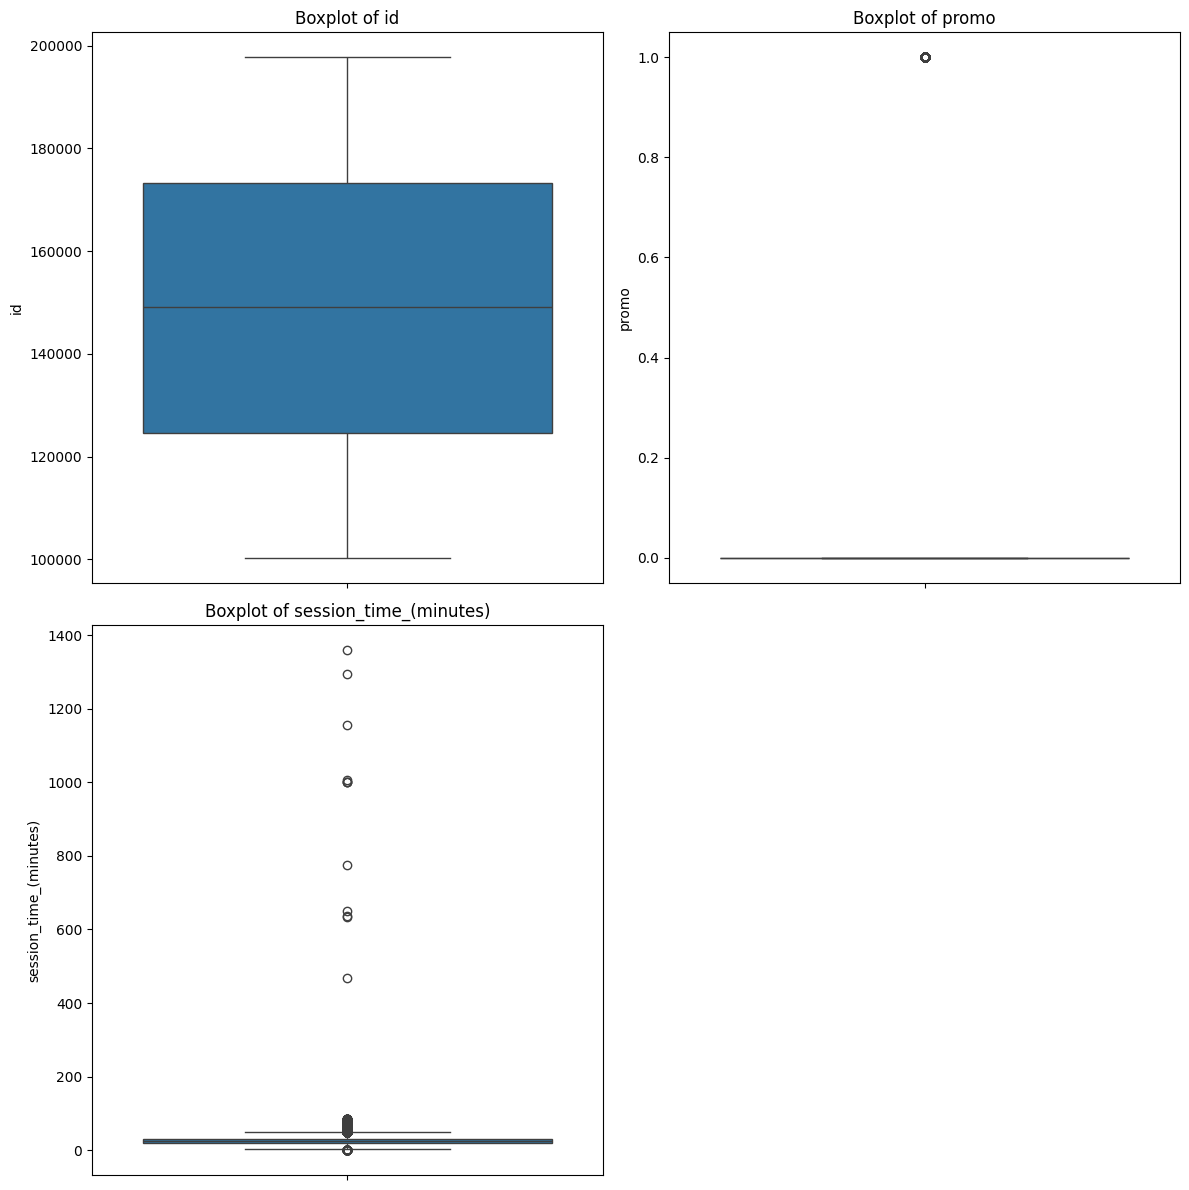

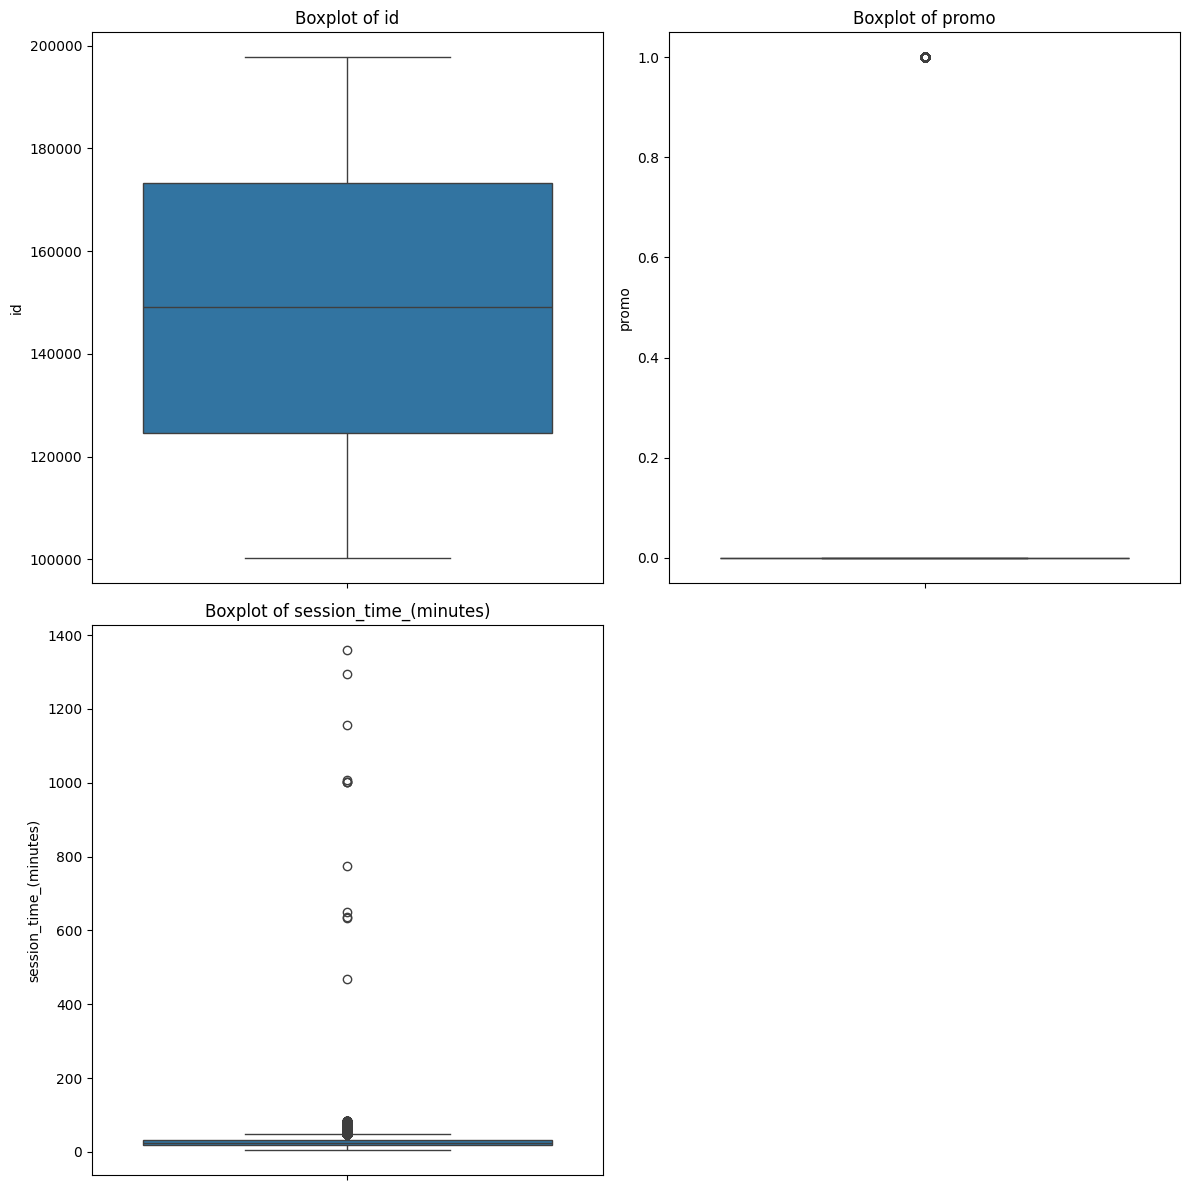

id          start_date            end_date start_location  \
0       100340 2023-04-22 09:01:03 2023-04-22 09:24:45       —à–µ–≤—á–µ–Ω–∫–æ   
1       100341 2023-04-22 09:01:07 2023-04-22 09:29:32         —á–µ—Ö–æ–≤–∞   
2       100342 2023-04-22 09:04:27 2023-04-22 09:42:46      –±—É–¥–µ–Ω–Ω–æ–≥–æ   
3       100343 2023-04-22 09:06:34 2023-04-22 09:38:23          —Ç—Ä—É–¥–∞   
4       100344 2023-04-22 09:09:27 2023-04-22 09:40:07   –ø–µ—Ä–≤–æ–º–∞–π—Å–∫–∞—è   
...        ...                 ...                 ...            ...   
102250  197707 2023-07-31 23:45:06 2023-08-01 00:06:55        –æ–∑–µ—Ä–Ω–∞—è   
102251  197708 2023-07-31 23:46:01 2023-08-01 00:25:35       –º–∏—á—É—Ä–∏–Ω–∞   
102252  197709 2023-07-31 23:48:04 2023-08-01 00:09:21     –ª–µ—Ä–º–æ–Ω—Ç–æ–≤–∞   
102253  197710 2023-07-31 23:51:41 2023-08-01 00:38:04      —Ä—è–±–∏–Ω–æ–≤–∞—è   
102254  197711 2023-07-31 23:57:01 2023-08-01 00:19:03     –º–æ–ª–æ–¥–µ–∂–Ω–∞—è   

         start_district  end_location     end_district  distance  promo  \
0         —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π       –º–∞–π—Å–∫–∞—è      –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4069      0   
1              –∑–∞—Ä–µ—á–Ω—ã–π    —Å–ø–æ—Ä—Ç–∏–≤–Ω–∞—è      –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      4515      0   
2           –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π      —Å—É–≤–æ—Ä–æ–≤–∞        –ª–µ–Ω–∏–Ω—Å–∫–∏–π      4520      0   
3           —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π       —Ä–∞–±–æ—á–∞—è  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π      3881      0   
4       —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π     —é–±–∏–ª–µ–π–Ω–∞—è    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π      4029      0   
...                 ...           ...              ...       ...    ...   
102250    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π  –ø–µ—Ä–≤–æ–º–∞–π—Å–∫–∞—è  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π      3302      0   
102251        –ª–µ–Ω–∏–Ω—Å–∫–∏–π       —Å–∞–¥–æ–≤–∞—è         –∑–∞—Ä–µ—á–Ω—ã–π      4992      0   
102252        –ª–µ–Ω–∏–Ω—Å–∫–∏–π     –∫—É–π–±—ã—à–µ–≤–∞      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      2781      0   
102253  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π   —ç–Ω–µ—Ä–≥–µ—Ç–∏–∫–æ–≤    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π      6466      0   
102254    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π   –º–∞—è–∫–æ–≤—Å–∫–æ–≥–æ      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      3561      0   

       session_time  session_time_(minutes)  
0          00:23:42                    23.7  
1          00:28:25                    28.4  
2          00:38:19                    38.3  
3          00:31:49                    31.8  
4          00:30:40                    30.7  
...             ...                     ...  
102250     00:21:49                    21.8  
102251     00:39:34                    39.6  
102252     00:21:17                    21.3  
102253     00:46:23                    46.4  
102254     00:22:02                    22.0  

[93222 rows x 11 columns]

In [112]:
df = clean_data_with_threshold(df, "distance", 1000, "below")
df

#### 4)–ø–æ—Å–º–æ—Ç—Ä–∏–º –∏ –ø–æ—á–∏—Å—Ç–∏–º –¥–∞–Ω–Ω—ã–µ –≤ session_time_(minutes)

In [113]:
df[df["session_time_(minutes)"]>=200]

id          start_date            end_date   start_location  \
7334    107304 2023-04-30 15:12:50 2023-05-19 23:01:44          –æ–∑–µ—Ä–Ω–∞—è   
10158   110004 2023-05-03 18:18:24 2023-05-27 07:13:18    –∫–æ–º—Å–æ–º–æ–ª—å—Å–∫–∞—è   
10326   110168 2023-05-03 20:21:01 2023-05-16 19:01:11          —Å–≤–æ–±–æ–¥—ã   
12064   111814 2023-05-05 21:39:02 2023-05-31 14:26:04         –∑–∞—Ä–µ—á–Ω–∞—è   
31853   130683 2023-05-27 15:23:31 2023-06-08 12:57:37        —Å–æ–≤—Ö–æ–∑–Ω–∞—è   
33911   132635 2023-05-28 21:57:48 2023-06-21 14:39:51       —Å–ø–æ—Ä—Ç–∏–≤–Ω–∞—è   
54273   152031 2023-06-17 16:13:03 2023-06-24 02:49:14      –º–∞—è–∫–æ–≤—Å–∫–æ–≥–æ   
59166   156662 2023-06-22 10:12:20 2023-07-14 02:53:29        –±–µ—Ä–µ–≥–æ–≤–∞—è   
63049   160352 2023-06-25 18:40:07 2023-07-13 11:21:53        —Å–æ–≤—Ö–æ–∑–Ω–∞—è   
78077   174691 2023-07-09 19:44:58 2023-07-31 06:35:30  –∂–µ–ª–µ–∑–Ω–æ–¥–æ—Ä–æ–∂–Ω–∞—è   
84077   180406 2023-07-15 16:51:18 2023-08-10 12:07:24        –Ω–µ–∫—Ä–∞—Å–æ–≤–∞   
102108  197572 2023-07-31 20:51:23 2023-08-14 07:25:37        —é–±–∏–ª–µ–π–Ω–∞—è   

         start_district end_location     end_district  distance  promo  \
7334      —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π      —á–∞–ø–∞–µ–≤–∞  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π   4227698      0   
10158          –∑–∞—Ä–µ—á–Ω—ã–π    –∑–∞–≤–æ–¥—Å–∫–∞—è  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π   5149229      0   
10326         –ª–µ–Ω–∏–Ω—Å–∫–∏–π        —é–∂–Ω–∞—è      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π   2831768      0   
12064     —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π    –∑–∞–≤–æ–¥—Å–∫–∞—è  —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π   5622015      0   
31853       —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π        —Ç—Ä—É–¥–∞      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π   2602970      0   
33911       –æ–∫—Ç—è–±—Ä—å—Å–∫–∏–π     –º–∏—á—É—Ä–∏–Ω–∞        –ª–µ–Ω–∏–Ω—Å–∫–∏–π   5183736      0   
54273       —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π    –º–∞—Ç—Ä–æ—Å–æ–≤–∞      —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π   1409216      0   
59166       —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      –æ–∑–µ—Ä–Ω–∞—è    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π   4746079      0   
63049       —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π  –æ–∫—Ç—è–±—Ä—å—Å–∫–∞—è         –∑–∞—Ä–µ—á–Ω—ã–π   3871126      0   
78077       —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–π      —á–∫–∞–ª–æ–≤–∞    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π   4692813      0   
84077   —Å–µ–≤–µ—Ä–æ-–∑–∞–ø–∞–¥–Ω—ã–π    —à–æ—Å—Å–µ–π–Ω–∞—è         –∑–∞—Ä–µ—á–Ω—ã–π   5644662      0   
102108    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π     –¥–æ—Ä–æ–∂–Ω–∞—è    —é–≥–æ-–≤–æ—Å—Ç–æ—á–Ω—ã–π   2940248      0   

       session_time  session_time_(minutes)  
7334       07:48:54                   468.9  
10158      12:54:54                   774.9  
10326      22:40:10                  1360.2  
12064      16:47:02                  1007.0  
31853      21:34:06                  1294.1  
33911      16:42:03                  1002.0  
54273      10:36:11                   636.2  
59166      16:41:09                  1001.2  
63049      16:41:46                  1001.8  
78077      10:50:32                   650.5  
84077      19:16:06                  1156.1  
102108     10:34:14                   634.2

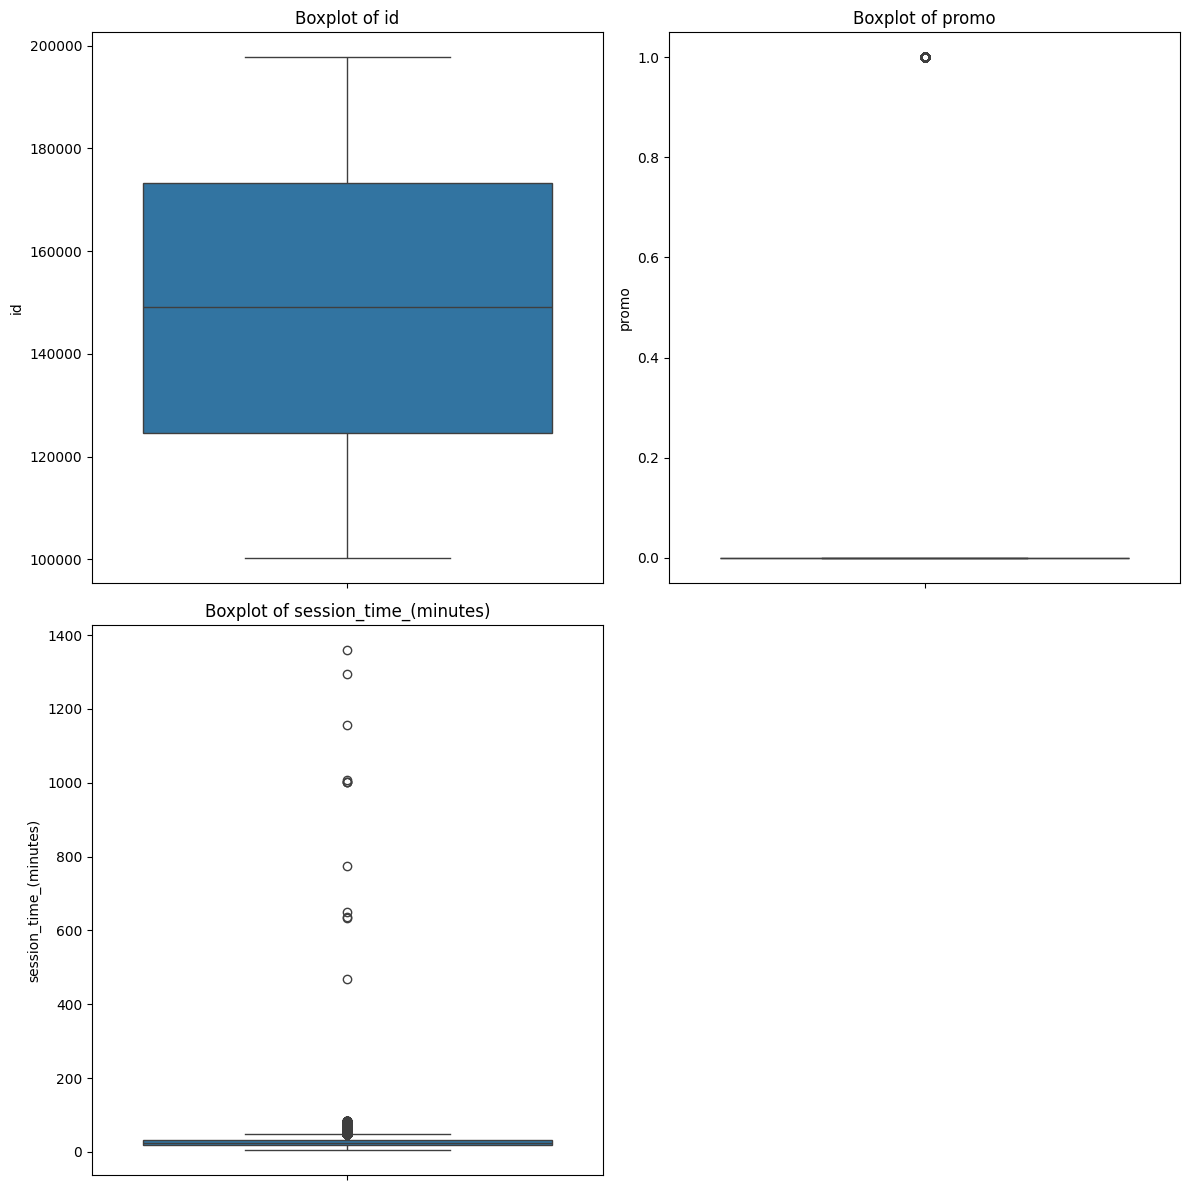

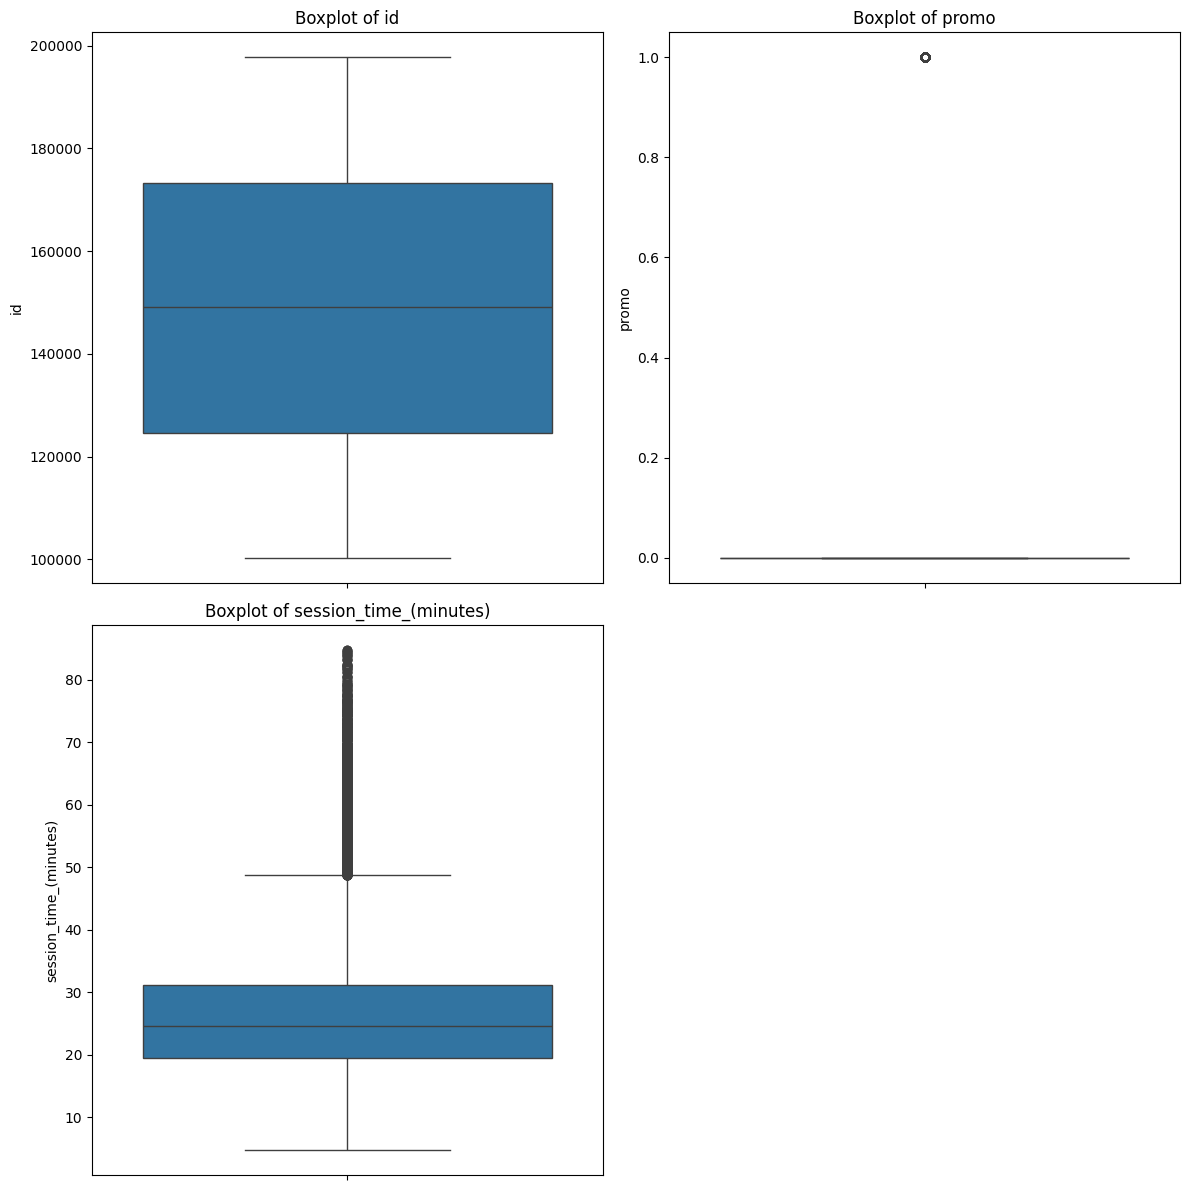

In [114]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 200, "above")

In [115]:
df[df["session_time_(minutes)"] <= 0]

Empty DataFrame
Columns: [id, start_date, end_date, start_location, start_district, end_location, end_district, distance, promo, session_time, session_time_(minutes)]
Index: []

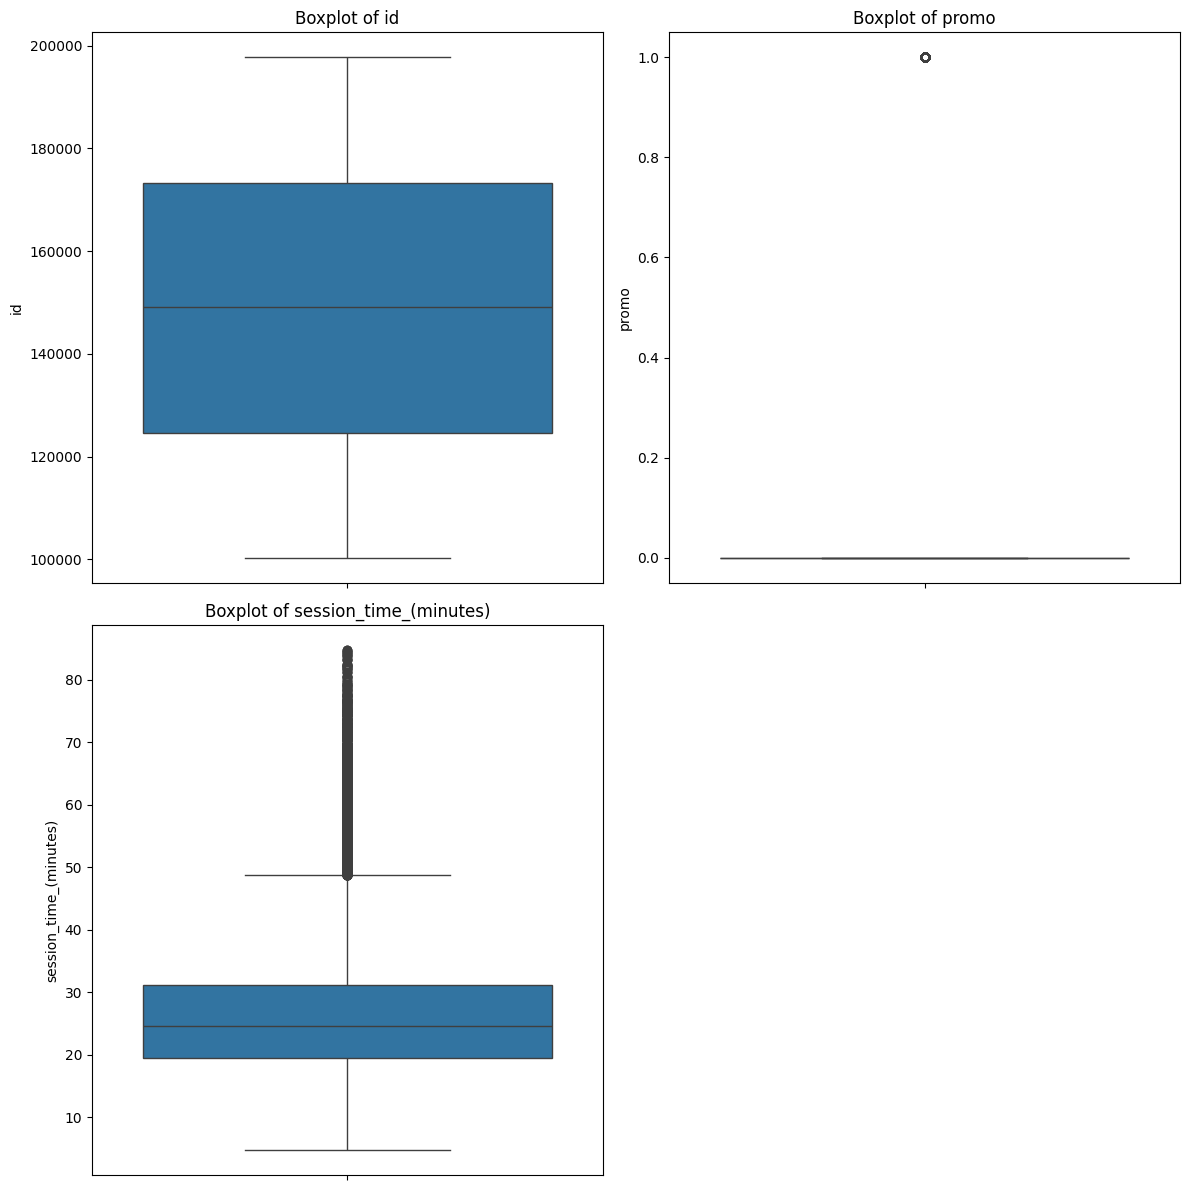

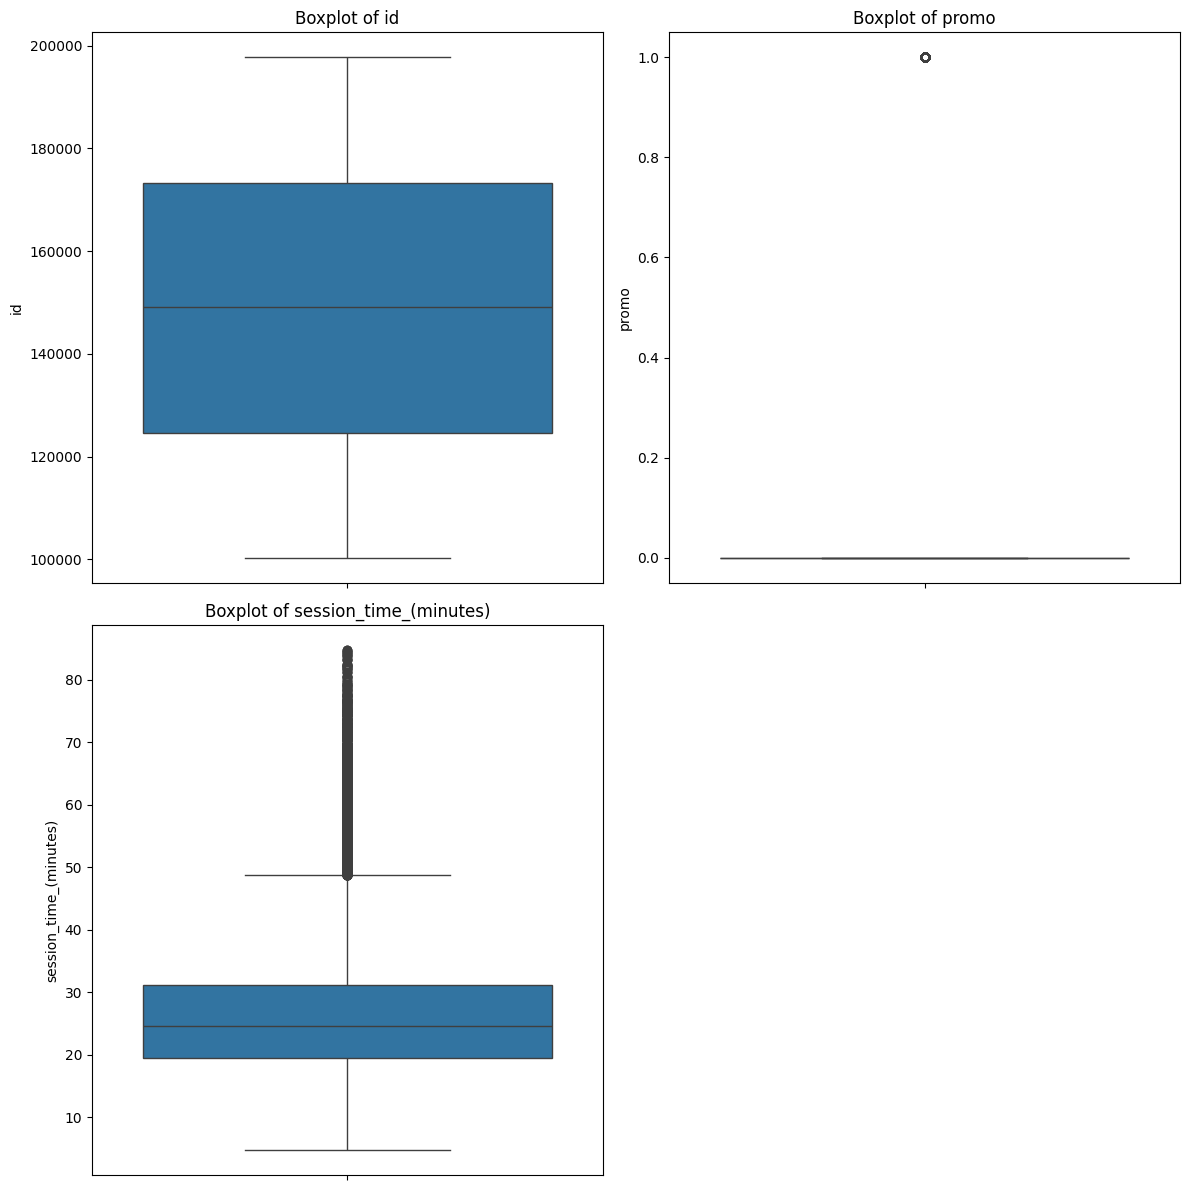

In [116]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 0, "below")

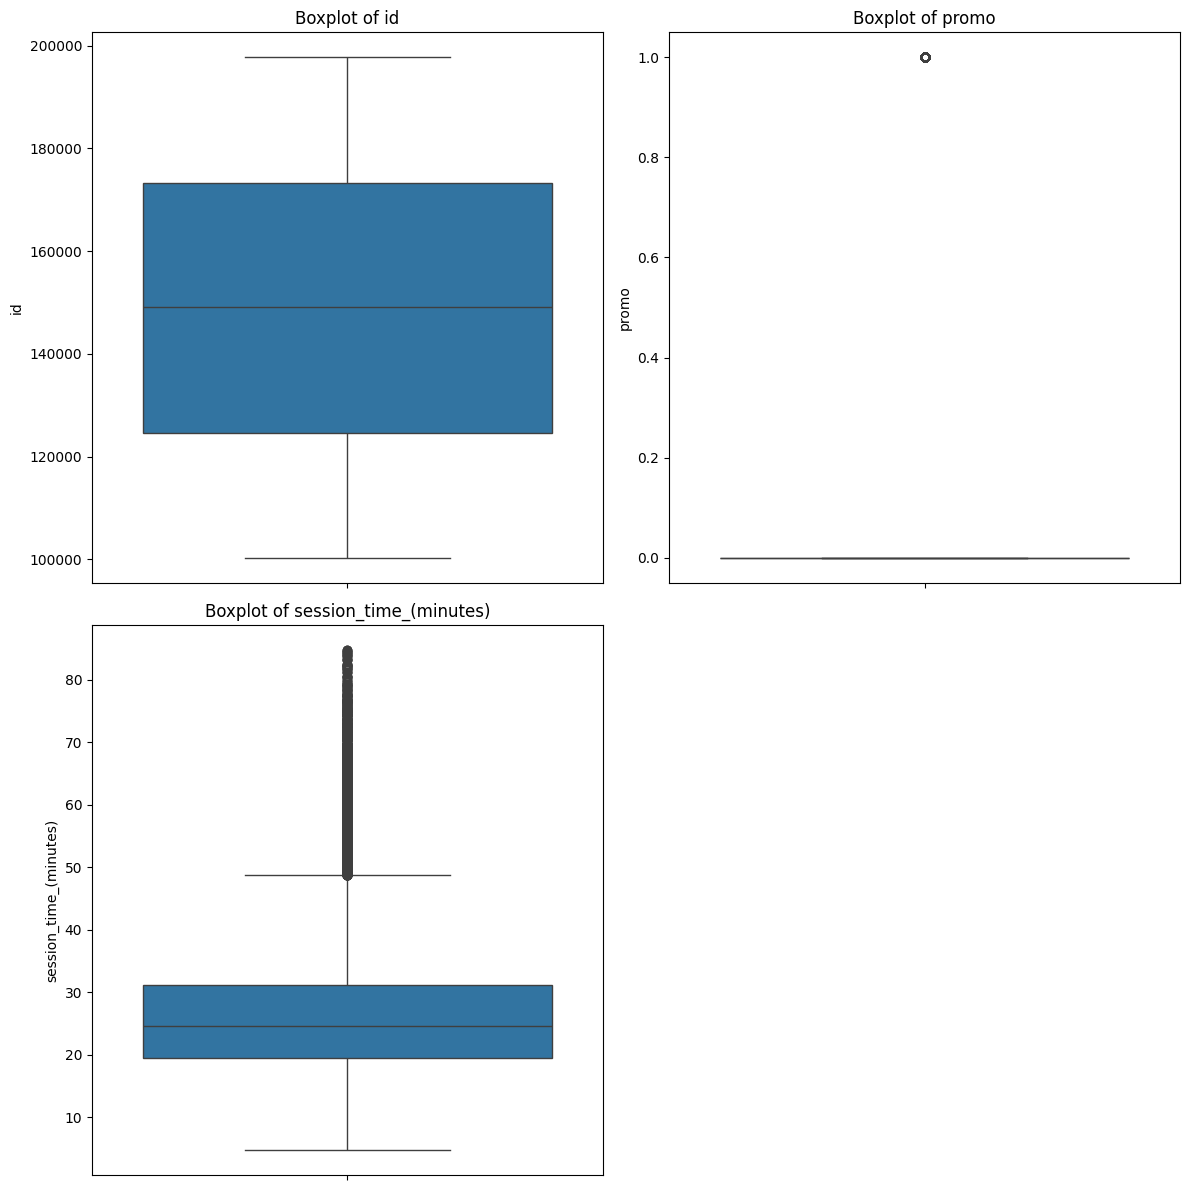

In [ ]:
cleaned_df = clean_data_with_threshold(cleaned_df, "session_time_(minutes)", 200, "above")

###### –ù—É–∂–Ω–æ –ª–∏ —É–±–∏—Ä–∞—Ç—å –¥–æ–ª–≥–∏–µ –ø–æ–µ–∑–¥–∫–∏?

# –û–±—â–∏–π –≤—ã–≤–æ–¥ –ø–æ –ø—Ä–æ–¥–µ–ª–∞–Ω–Ω–æ–π —Ä–∞–±–æ—Ç–µ –Ω–∞ —Å–ø—Ä–∏–Ω—Ç —Å 01 –ø–æ 06 –∞–ø—Ä–µ–ª—è
–ü—Ä–æ–≤–µ–¥–µ–Ω –¥–µ—Ç–∞–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑ –¥–≤—É—Ö –¥–∞—Ç–∞—Å–µ—Ç–æ–≤:  
- rides.csv (–¥–∞–Ω–Ω—ã–µ –æ –ø–æ–µ–∑–¥–∫–∞—Ö):  
  - –û–±–Ω–∞—Ä—É–∂–µ–Ω—ã –∞–Ω–æ–º–∞–ª–∏–∏ –≤ –¥–∏—Å—Ç–∞–Ω—Ü–∏–∏ (Distance) –∏ –≤—Ä–µ–º–µ–Ω–∏ —Å–µ—Å—Å–∏–∏ (Session Time).  
  - –í—ã—è–≤–ª–µ–Ω—ã –ø–æ–ª–Ω—ã–µ –¥—É–±–ª–∏–∫–∞—Ç—ã (4,831) –∏ –ø—Ä–æ–ø—É—Å–∫–∏ (555) –≤ –¥–∞—Ç–∞—Ö –æ–∫–æ–Ω—á–∞–Ω–∏—è –ø–æ–µ–∑–¥–æ–∫.  
  - –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (—Ä–∞–π–æ–Ω—ã, –ª–æ–∫–∞—Ü–∏–∏) —Ç—Ä–µ–±—É—é—Ç —Å—Ç–∞–Ω–¥–∞—Ä—Ç–∏–∑–∞—Ü–∏–∏.  
- weather.csv (–ø–æ–≥–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ):  
  - –î–∞–Ω–Ω—ã–µ —Ö—Ä–∞–Ω—è—Ç—Å—è –≤ –Ω–µ–æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–º —Ñ–æ—Ä–º–∞—Ç–µ (–µ–¥–∏–Ω–∏—Ü—ã –∏–∑–º–µ—Ä–µ–Ω–∏—è –≤ —è—á–µ–π–∫–∞—Ö, —Å—Ç—Ä–æ–∫–æ–≤—ã–µ —á–∏—Å–ª–∞).
  - –ü—Ä–æ–≤–µ–¥–µ–Ω–∞ –æ—á–∏—Å—Ç–∫–∞ –∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —Ç–∏–ø–æ–≤.
  - –ü—Ä–æ–≤–µ–¥–µ–Ω–æ –∑–∞–ø–æ–ª–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ –ø—É—Ç—ë–º –∏–Ω—Ç–µ—Ä–ø–æ–ª—è—Ü–∏–∏

–†–∞–±–æ—Ç–∞ —Å–¥–µ–ª–∞–ª–∞ –æ—Å–Ω–æ–≤—É –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–≥–æ —É–≥–ª—É–±–ª–µ–Ω–Ω–æ–≥–æ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è. üöÄ